In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

from RIS_gravity_inversion import regional, synthetic, plotting, optimization
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.gravity_processing as grav
import RIS_gravity_inversion.uncertainties as uncert

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import geopandas as gpd
import plotly.graph_objects as go
import plotly.express as px
import plotly
import plotly.figure_factory as ff
import seaborn as sns

sns.set_theme()
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import itertools
import pickle
import random

import os

# make beep sound when notify is called at end of long-running cells
from IPython.display import Audio

wave = np.sin(2 * np.pi * 400 * np.arange(10000 * 1) / 10000)
notify = Audio(wave, rate=10000, autoplay=True)

In [2]:
plot = True
# plot = False
runs = 10

# Load inversion inputs

In [3]:
# weights grid and starting bathymetry
starting_prisms = xr.open_zarr(
    "../inversion_layers/RIS_starting_bed_prisms_mean.zarr",
    # "../inversion_layers/RIS_starting_bed_prisms_verde_spline.zarr",
    # "../inversion_layers/RIS_starting_bed_prisms_gmt_surface.zarr",
)

# partial bouguer corrected gravity data
df_anomalies = pd.read_csv(
    "../data/RIS_topo_corrections_levelled_mean_bed.csv.gz",
    # "../data/RIS_topo_corrections_levelled_verde_spline.csv.gz",
    # "../data/RIS_topo_corrections_levelled_gmt_surface.csv.gz",sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set regions
starting_region = [-580e3, 420e3, -1420e3, -420e3]

inversion_region = starting_region
buffer_region = vd.pad_region(starting_region, 40e3)

# set layer parameters
layer_spacing = 5e3
registration = "g"

print(f"layer spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

# get starting bed model
# fname = "../inversion_layers/bed_from_constraints_verde_spline.zarr"
# fname = "../inversion_layers/bed_from_constraints_gmt_surface.zarr"
# bed_from_constraints = xr.open_zarr(fname).bed

fname = "../inversion_layers/RIS_starting_bed_stats.zarr"
bed_from_constraints = xr.open_zarr(fname).weighted_mean

# resample at layer spacing
bed_from_constraints = fetch.resample_grid(
    bed_from_constraints,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)

constraints_fname = "../data/bed_constraints.csv.gz"
constraints = pd.read_csv(
    constraints_fname,
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
# ensure all points are within buffer region
constraints = utils.points_inside_region(
    constraints, buffer_region, names=("easting", "northing")
)
print(f"bathymetry control points:{len(constraints)}")

# get bedmachine data
# surface
fname = "../inversion_layers/bedmachine_surface.zarr"
bedmachine_surface_full = xr.open_zarr(fname).surface
# icebase
fname = "../inversion_layers/bedmachine_icebase.zarr"
bedmachine_icebase_full = xr.open_zarr(fname).icebase
# bed
fname = "../inversion_layers/bedmachine_bed.zarr"
bedmachine_bed_full = xr.open_zarr(fname).bed

# resample bedmachine data at new spacing
bedmachine_surface_1k = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmachine_icebase_1k = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)
bedmachine_bed_1k = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=1e3,
    registration=registration,
    region=buffer_region,
    verbose="q",
)

# resample bedmachine data at layer spacing
bedmachine_surface_layer_spacing = fetch.resample_grid(
    bedmachine_surface_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_icebase_layer_spacing = fetch.resample_grid(
    bedmachine_icebase_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
bedmachine_bed_layer_spacing = fetch.resample_grid(
    bedmachine_bed_full,
    spacing=layer_spacing,
    region=buffer_region,
    registration=registration,
    verbose="q",
)
# ensure layers never cross
bedmachine_icebase_layer_spacing = xr.where(
    bedmachine_icebase_layer_spacing > bedmachine_surface_layer_spacing,
    bedmachine_surface_layer_spacing,
    bedmachine_icebase_layer_spacing,
)
bed_from_constraints = xr.where(
    bed_from_constraints > bedmachine_icebase_layer_spacing,
    bedmachine_icebase_layer_spacing,
    bed_from_constraints,
)

# # final inverted bathymetry model
# fname = "../results/weights_mask_prism_results.csv.gz"
# inverted_bathy = pd.read_csv(
#     fname,
#     sep=",",
#     header="infer",
#     index_col=None,
#     compression="gzip",
# )
# inverted_bathy = inverted_bathy.set_index(["northing", "easting"]).to_xarray()[
#     inverted_bathy.columns[-1]
# ]

layer spacing: 5000.0m
registration: g
inversion region =  [-580000.0, 420000.0, -1420000.0, -420000.0]
buffer region =  (-620000.0, 460000.0, -1460000.0, -380000.0)
bathymetry control points:28087
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling


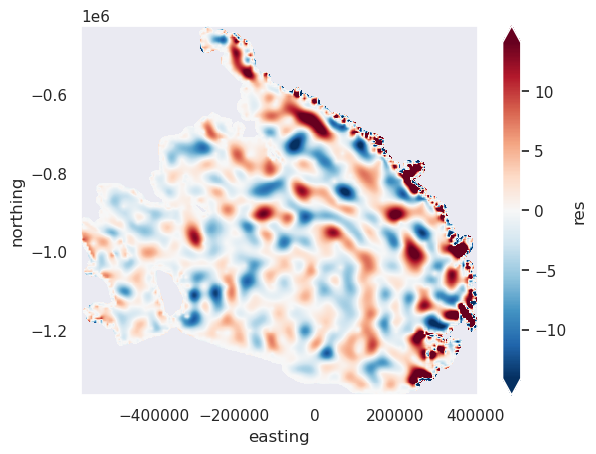

In [4]:
df_anomalies.set_index(["northing", "easting"]).to_xarray().res.plot(robust=True)

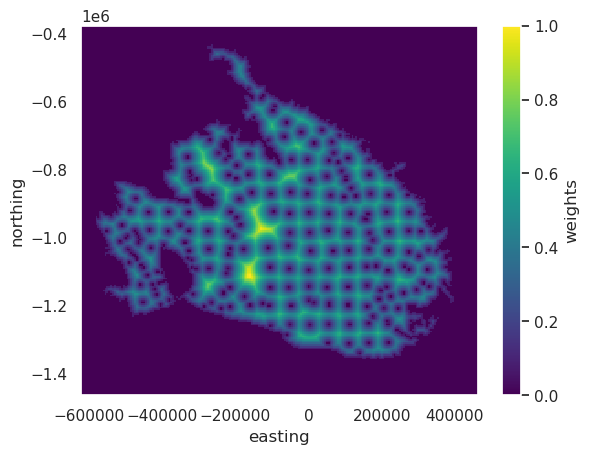

In [5]:
weights_grid = inv_utils.normalized_mindist(
    constraints,
    starting_prisms,
    mindist=layer_spacing / np.sqrt(2),
    low=0,
    high=1,
    region=inversion_region,
)
starting_prisms["weights"] = weights_grid
starting_prisms.weights.plot()

# Add uncertainties 
3.3 mGal for gravity data, RMS cross-over after levelling.

10% depth from ice surface for constraints within ice shelf

In [6]:
# constraints["low_lim"] = constraints.upward - constraints.z_error
# constraints["high_lim"] = constraints.upward + constraints.z_error

print(
    f"mean uncertainty inside RIS: {np.nanmean(constraints[constraints.inside].z_error)} m"
)
print(
    f"mean uncertainty outside RIS: {np.nanmean(constraints[constraints.inside==False].z_error)} m"
)

constraints.describe()

mean uncertainty inside RIS: 35.98642118025852 m
mean uncertainty outside RIS: 10.0 m


northing        easting        upward       z_error       weights
count  2.808700e+04   28087.000000  28087.000000  28087.000000  28087.000000
mean  -8.756051e+05  -90456.515288    -36.964407     10.206322      0.009928
std    3.686328e+05  357858.552976   1012.006206      2.418512      0.000809
min   -1.460000e+06 -620000.000000  -3684.761230     10.000000      0.000191
25%   -1.280917e+06 -425000.000000   -653.772156     10.000000      0.010000
50%   -7.550000e+05 -120000.000000   -456.829468     10.000000      0.010000
75%   -5.450000e+05  270000.000000    554.266388     10.000000      0.010000
max   -3.800000e+05  460000.000000   4054.422607     72.332364      0.010000

In [7]:
df_anomalies["uncert"] = 3.3
df_anomalies

northing   easting   test  upward       Gobs  inside  \
0     -1365000.0  147500.0   True  1000.0 -21.437198    True   
1     -1365000.0  150000.0  False  1000.0 -22.503368    True   
2     -1365000.0  152500.0   True  1000.0 -23.521033    True   
3     -1365000.0  155000.0  False  1000.0 -24.474428    True   
4     -1365000.0  157500.0   True  1000.0 -25.353009    True   
...          ...       ...    ...     ...        ...     ...   
85909  -427500.0 -262500.0   True  1000.0 -52.962891    True   
85910  -427500.0 -260000.0   True  1000.0 -54.814527    True   
85911  -427500.0 -257500.0   True  1000.0 -56.674146    True   
85912  -425000.0 -265000.0  False  1000.0 -50.846823    True   
85913  -425000.0 -262500.0   True  1000.0 -52.492212    True   

       ice_surface_grav  water_surface_grav  starting_bed_grav  \
0             -2.032417           -0.271613         -40.685208   
1             -2.031799           -0.272119         -40.819507   
2             -2.031245           -0.272546         -40.782656   
3             -2.030761           -0.272887         -40.678516   
4             -2.030344           -0.273143         -40.457919   
...                 ...                 ...                ...   
85909          6.301771           -2.854282         -33.516579   
85910          7.205060           -2.832430         -33.260550   
85911          8.138428           -2.768166         -32.508235   
85912          6.105235           -2.078981         -24.415316   
85913          7.097374           -2.183951         -25.647161   

       partial_topo_corrected_disturbance     misfit        reg       res  \
0                              -19.133169  21.552039  21.972942 -0.420903   
1                              -20.199450  20.620057  20.758575 -0.138518   
2                              -21.217241  19.565415  19.552794  0.012621   
3                              -22.170780  18.507737  18.369875  0.137862   
4                              -23.049522  17.408397  17.238495  0.169902   
...                                   ...        ...        ...       ...   
85909                          -56.410379 -22.893800 -21.887625 -1.006175   
85910                          -59.187157 -25.926607 -24.828747 -1.097860   
85911                          -62.044408 -29.536173 -28.721795 -0.814378   
85912                          -54.873077 -30.457762 -23.821194 -6.636568   
85913                          -57.405636 -31.758475 -26.022706 -5.735769   

       uncert  
0         3.3  
1         3.3  
2         3.3  
3         3.3  
4         3.3  
...       ...  
85909     3.3  
85910     3.3  
85911     3.3  
85912     3.3  
85913     3.3  

[85914 rows x 14 columns]

# Setup Monte-Carlo sampling
* define sampling methods for the uncertainties of both the gravity and constraints data
* run full inversion with sampled gravity
    * including: 
        * corrections for parital bouguer and starting bed
        * DC shift
        * regional / residual seperation
        * inversion
* find standard deviation per grid cell of all resulting inverted bathymetry models

## Run inversion workflow

In [8]:
# get RIS mask
measures_shelves = fetch.measures_boundaries(version="IceShelf")
ice_shelves = gpd.read_file(measures_shelves)
RIS_seperate = ice_shelves[ice_shelves.NAME.isin(["Ross_West", "Ross_East"])]
RIS = RIS_seperate.dissolve()

# get points within ice shelf border and buffered border
buffer_points, _, bed_outside = inv_utils.get_buffer_points(
    buffer_width=1e3,
    grid=bedmachine_bed_1k,
    mask=RIS,
    # plot = True,
)

In [9]:
# bed_from_constraints = inv_utils.recreate_bed(
#     inside_points = constraints[constraints.inside],
#     buffer_points = buffer_points,
#     outside_grid = bed_outside,
#     region = buffer_region,
#     fullres_spacing = 1e3,
#     layer_spacing = layer_spacing,

#     method = "spline",
#     damping = 10e-50,

#     # method = "surface",
#     # tension = 0,

#     icebase = bedmachine_icebase_layer_spacing,
#     surface = bedmachine_surface_layer_spacing,
#     icebase_fullres = bedmachine_icebase_1k,
#     surface_fullres = bedmachine_surface_1k,
# )

In [10]:
kwargs = dict(
    grav_spacing=layer_spacing,
    inversion_region=inversion_region,
    buffer_region=buffer_region,
    layer_spacing=layer_spacing,
    # optional:
    weights_grid=weights_grid,
    starting_bed_prisms=starting_prisms,
    starting_bed=bed_from_constraints,
    solver_damping=10**-2,
    # recreate bed kwargs:
    buffer_points=buffer_points,
    bed_outside=bed_outside,
    fullres_spacing=1e3,
    # damping CV kwargs:
    CV_damping_values=np.logspace(-4, -1, 6),
    # CV_damping_values = [-2],
    # CV_damping_values = np.logspace(-4, -2, 1),
    # kwargs for multiple things:
    icebase_layer_spacing=bedmachine_icebase_layer_spacing,
    surface_layer_spacing=bedmachine_surface_layer_spacing,
    icebase_fullres=bedmachine_icebase_1k,
    surface_fullres=bedmachine_surface_1k,
)

inversion_args = dict(
    input_grav_column="partial_topo_corrected_disturbance",
    apply_weights=False,
    weights_after_solving=True,
    max_iterations=50,
    l2_norm_tolerance=0.15,
    delta_l2_norm_tolerance=1.005,
    upper_confining_layer=bedmachine_icebase_layer_spacing,
    deriv_type="annulus",
    solver_type="scipy least squares",
)

starting_args = dict(
    ice_density=915,
    water_density=1024,
    sediment_density=2300,
    regional_tension_factor=0.5,
    regional_damping=10**-20,
    regional_grid_method="pygmt",
    starting_bed_tension=0.5,
    starting_bed_damping=10**-25,
    starting_bed_method="surface",
)

In [11]:
# # rand = np.random.default_rng(seed=i)
# mu, sigma = 2300, 400 # mean and standard deviation
# s = np.random.normal(mu, sigma, 20)
# count, bins, ignored = plt.hist(s, 30, density=True)
# plt.plot(
#     bins,
#     1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
#     linewidth=2,
#     color='r',
# )

# plt.show()

In [12]:
# # rand = np.random.default_rng(seed=i)
# mu, sigma = 2300, 400 # mean and standard deviation
# s = np.random.normal(mu, sigma, 1000)
# count, bins, ignored = plt.hist(s, 10, density=True)
# plt.show()

In [13]:
# from UQpy.sampling import LatinHypercubeSampling as LHS
# from UQpy.distributions import Uniform, Normal
# from UQpy.sampling.stratified_sampling.latin_hypercube_criteria import *

# sample_starting_bed_tension = True
# sample_starting_bed_damping = False
# sample_regional_tension_factor = False
# sample_regional_damping = True

# dists = {}
# if sample_starting_bed_tension is True:
#     dists["starting_bed_tension"]=Normal(loc=0, scale=1)
# if sample_starting_bed_damping is True:
#     dists["starting_bed_damping"]=Uniform(loc=10**-40, scale=10**-10)
# if sample_regional_tension_factor is True:
#     dists["regional_tension_factor"]=Uniform(loc=0, scale=1)
# if sample_regional_damping is True:
#     dists["regional_damping"]=Uniform(loc=10**-45, scale=10**-5)

# nsamples = 10

# lhs = LHS(
#     distributions=[v for k,v in dists.items()],
#     # criterion=Centered(),
#     criterion=Random(),
#     random_state=np.random.RandomState(1),
#     nsamples=nsamples,
# )

# samples = lhs._samples
# print(samples)

# s0 = samples[:,0]
# print(s0)

# count, bins, ignored = plt.hist(s0, 5, density=True)
# plt.show()

In [14]:
# count, bins, ignored = plt.hist(values_df.sediment_density, 10, density=True)
# plt.show()

## Full (gravity, constraints, density)

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

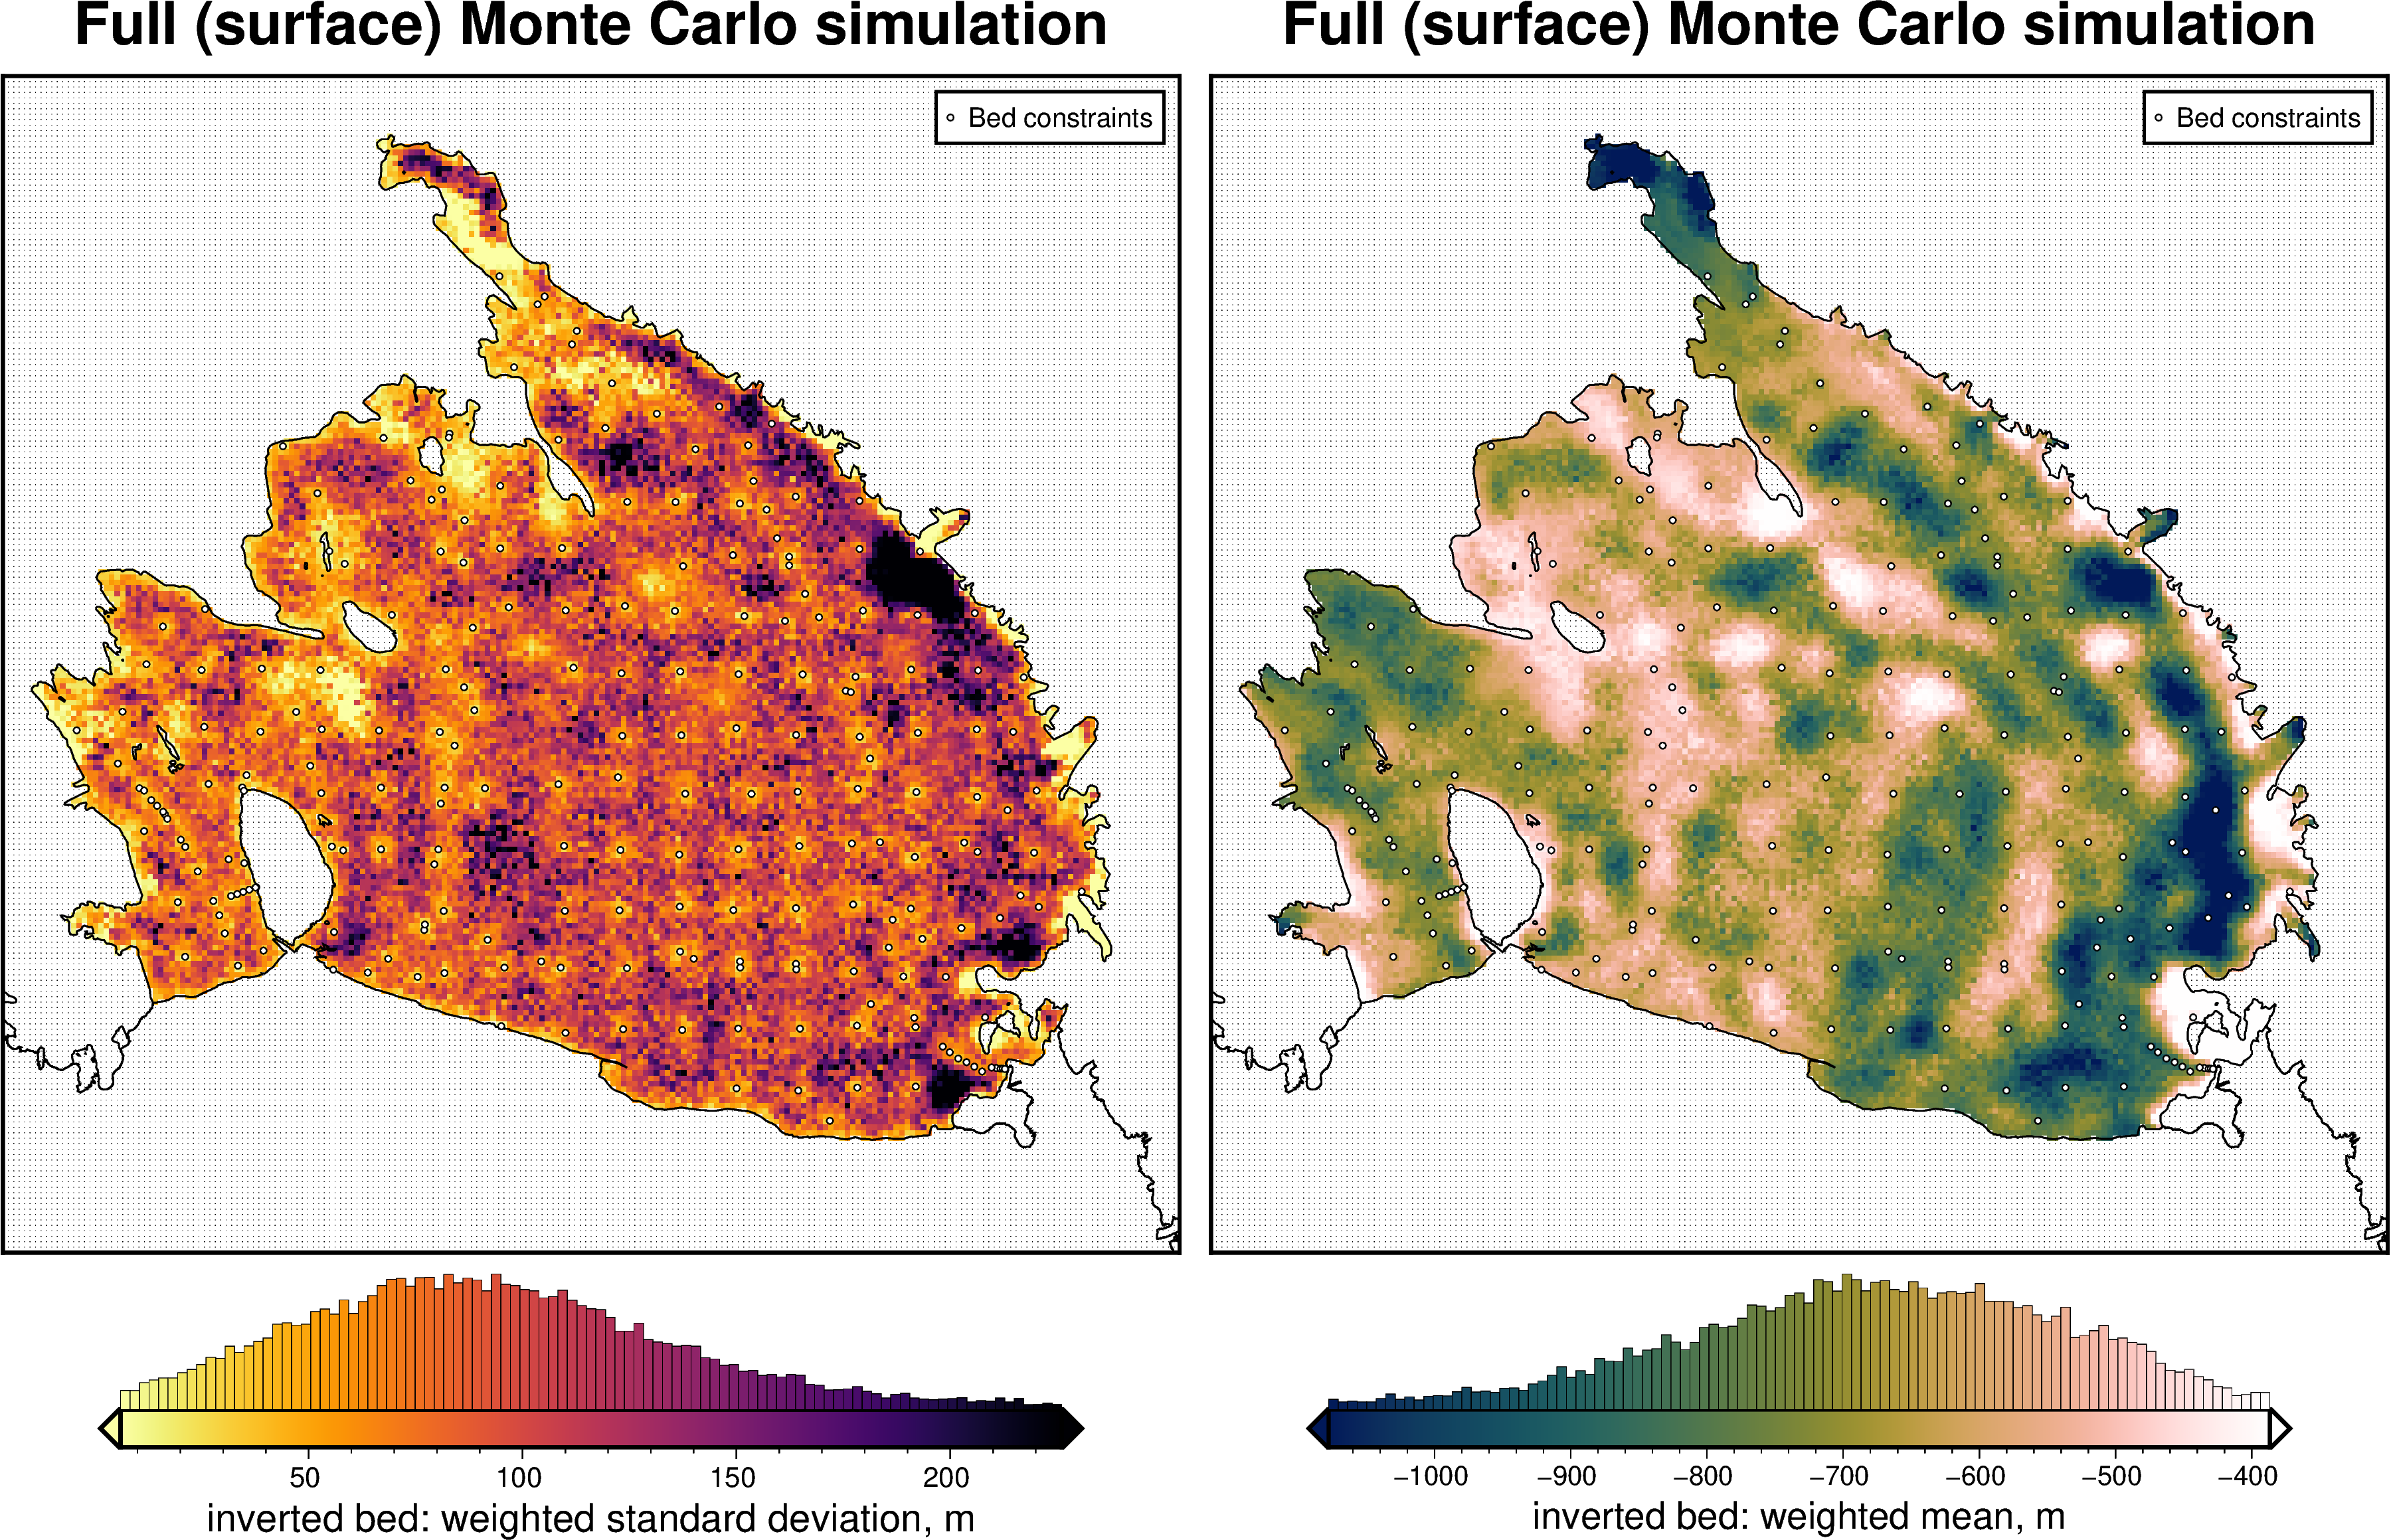

In [17]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_full_gmt_surface"
# fname = path + prefix

# full_surface_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     sample_grav=True,  # will recalculate regional field
#     sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field

#     sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     sampling="LHC",
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = full_surface_results

# # ds = uncert.merged_stats(
# #     full_surface_results,
# #     "topo",
# #     "starting_bed",
# #     plot=plot,
# #     mask="../plotting/RIS_outline.shp",
# #     title="Full (surface) Monte Carlo simulation",
# #     constraints=constraints,
# # )
# ds = uncert.merged_stats(
#     full_surface_results,
#     "topo",
#     -1,
#     plot=plot,
#     # plot=False,
#     mask="../plotting/RIS_outline.shp",
#     title="Full (surface) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

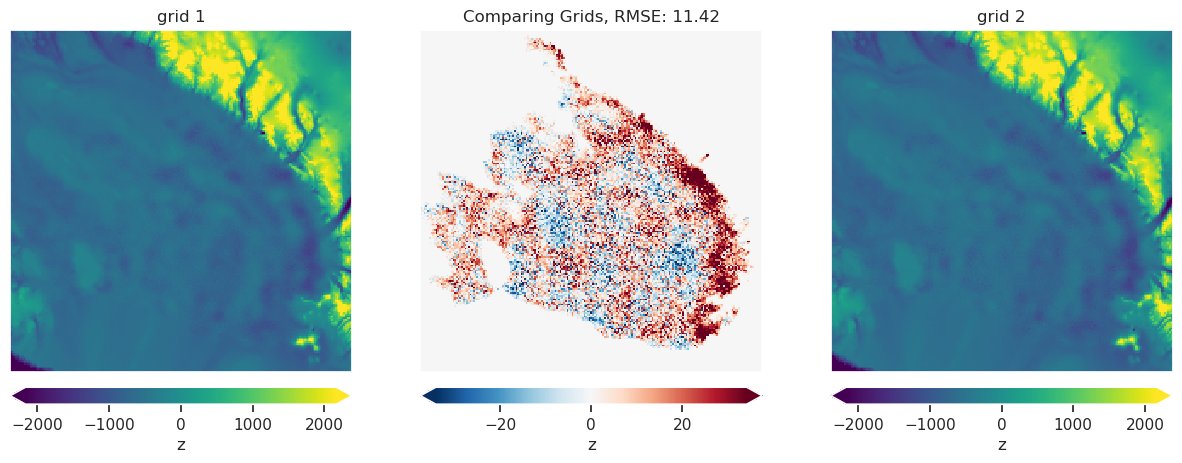

In [16]:
# _ = utils.grd_compare(
#     ds.z_mean, ds.weighted_mean,
#     region=inversion_region,
#     plot=True, plot_type="xarray",
#     shp_mask="../plotting/RIS_outline.shp", robust=True)

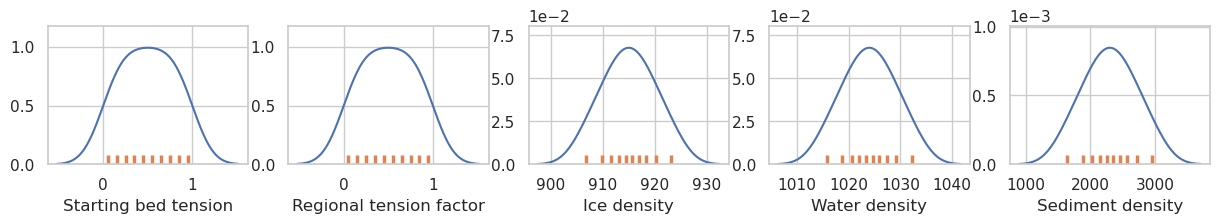

In [239]:
# df = pd.DataFrame(values).drop(columns=["starting_bed_damping", "regional_damping"])

# fig, axes = plt.subplots(
#     1, len(df.columns), figsize=(3*len(df.columns), 1.8),)

# for i, j in enumerate(df.columns):
#     sns.kdeplot(ax=axes[i], data=df, x=j,)
#     sns.rugplot(ax=axes[i], data=df, x=j,
#                 linewidth=2.5, height=.07)
#     axes[i].set_xlabel(j.replace("_", " ").capitalize())
#     axes[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#     axes[i].set_ylabel(None)

# fig.show()

In [ ]:
# values_df.ice_density.min(), values_df.ice_density.max()

(906.7757318652426, 923.2242681347574)

In [40]:
# values_df.water_density.min(), values_df.water_density.max()

(1015.7757318652426, 1032.2242681347573)

In [41]:
# values_df.sediment_density.min(), values_df.sediment_density.max()

(1642.058549219411, 2957.9414507805886)

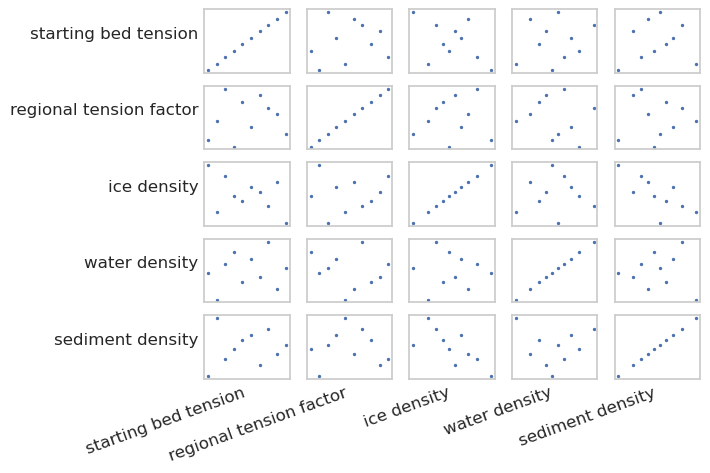

In [237]:
# sns.set_style("whitegrid")

# n = np.shape(df)[0]
# dim = np.shape(df)[1]

# param_values = df.values

# problem = {
#     'num_vars': dim,
#     'names': [i.replace("_", " ") for i in df.columns],
#     'bounds': [[-1, 1]]*dim
# }

# # Rescale to the unit hypercube for the analysis
# sample = uncert.scale_normalized(param_values, problem["bounds"])

# # Correlation properties
# [z_mk, pval_mk] = uncert.mann_kendall_test_sample(sample)
# [rho, pval_pr] = uncert.pearson_test_sample(sample)
# # uncert.correlation_plots(z_mk, pval_mk, 'Mann-Kendall', problem['names'])
# # uncert.correlation_plots(rho, pval_pr, 'Pearson', problem['names'])

# #################################
# # Space-filling properties

# # 1D projection
# # x = uncert.projection_1D(sample, problem['names'])
# # print('\nOn a [0, 1] scale 1D coverage is: ' + str(x))

# # 2D projection (manageable number of variables, here fixed at 11)
# if problem["num_vars"] < 11:
#     uncert.projection_2D(sample, problem['names'])

# # L2-star discrepancy
# # dl2 = uncert.space_filling_measures_discrepancy(sample)
# # print('\nL2-star discrepancy is: ' + str(dl2))

# # Minimal distance between any two points
# # d = uncert.space_filling_measures_min_distance(sample, 1)
# # print('\nThe minimal distance between two points is: ' + str(d) + '\n')

## Gravity

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

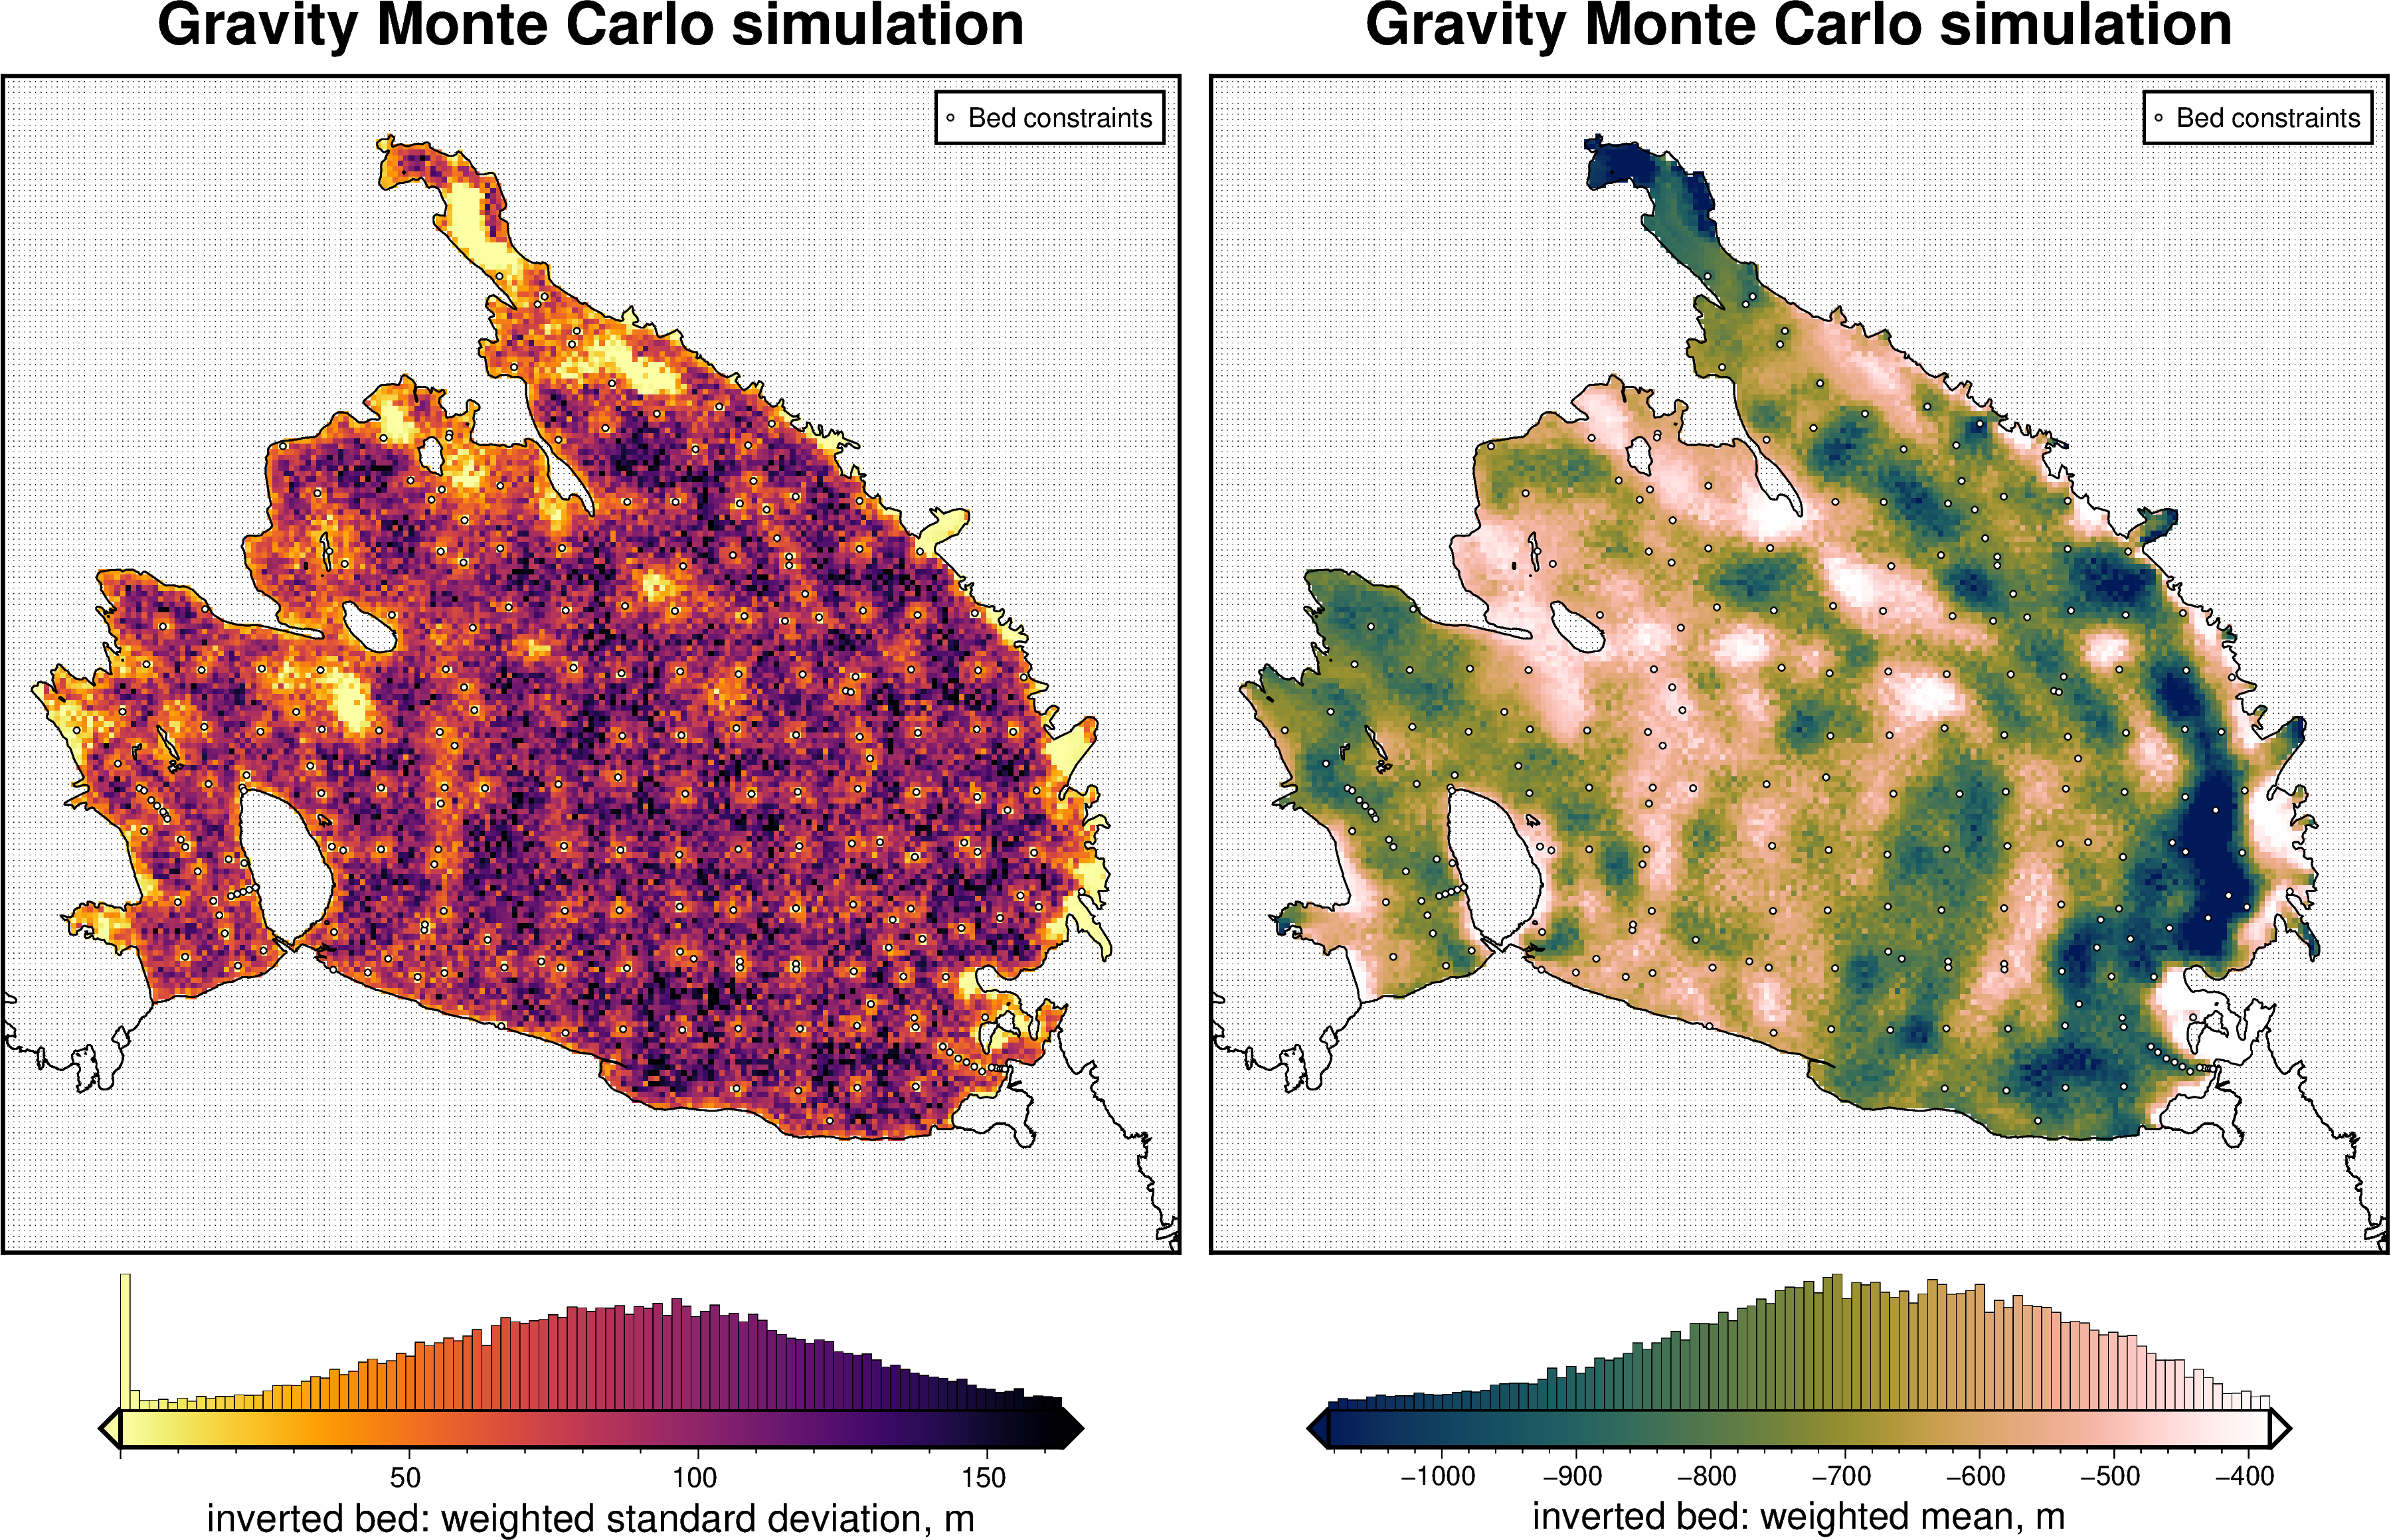

In [18]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_gravity"
# fname = path + prefix

# gravity_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     sample_grav=True,  # will recalculate regional field
#     # sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     sampling="LHC",
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = gravity_results

# # ds = uncert.merged_stats(
# #     gravity_results,
# #     "grav",
# #     "misfit",
# #     plot=plot,
# #     mask="../plotting/RIS_outline.shp",
# #     title="Gravity Monte Carlo simulation",
# #     constraints=constraints,
# #     weight_by="constraints",
# # )
# ds = uncert.merged_stats(
#     gravity_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Gravity Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Constraints

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

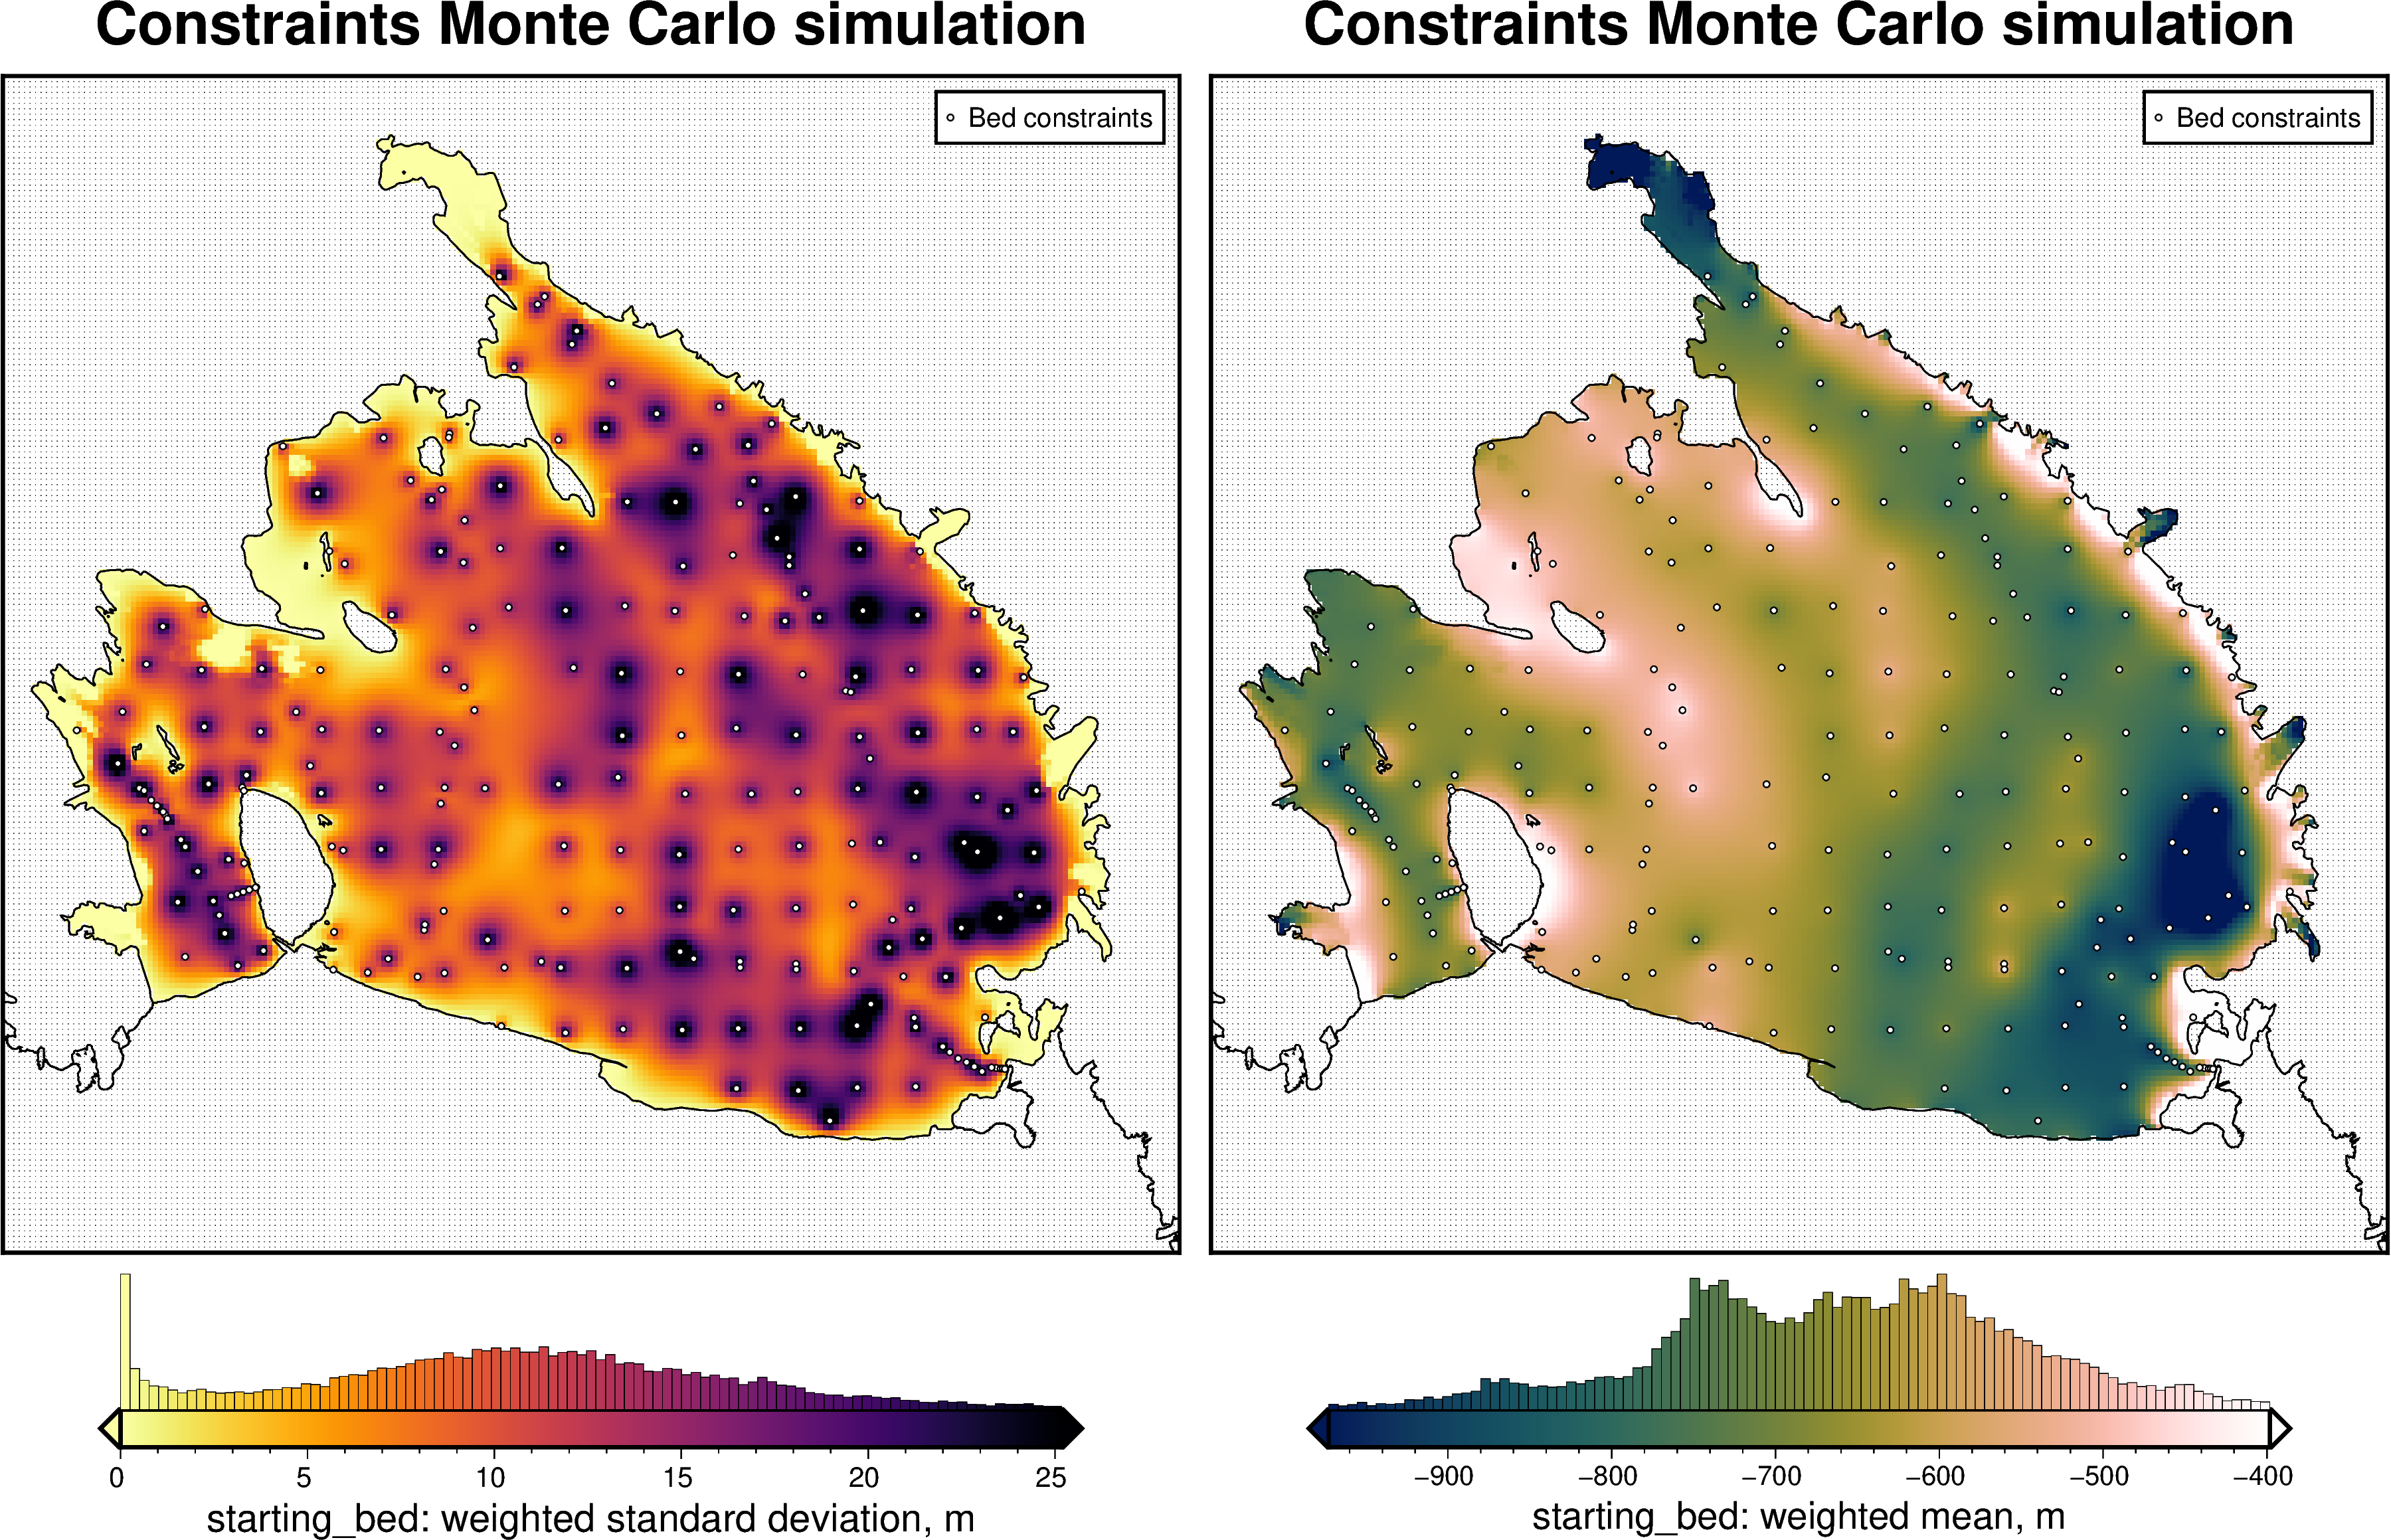

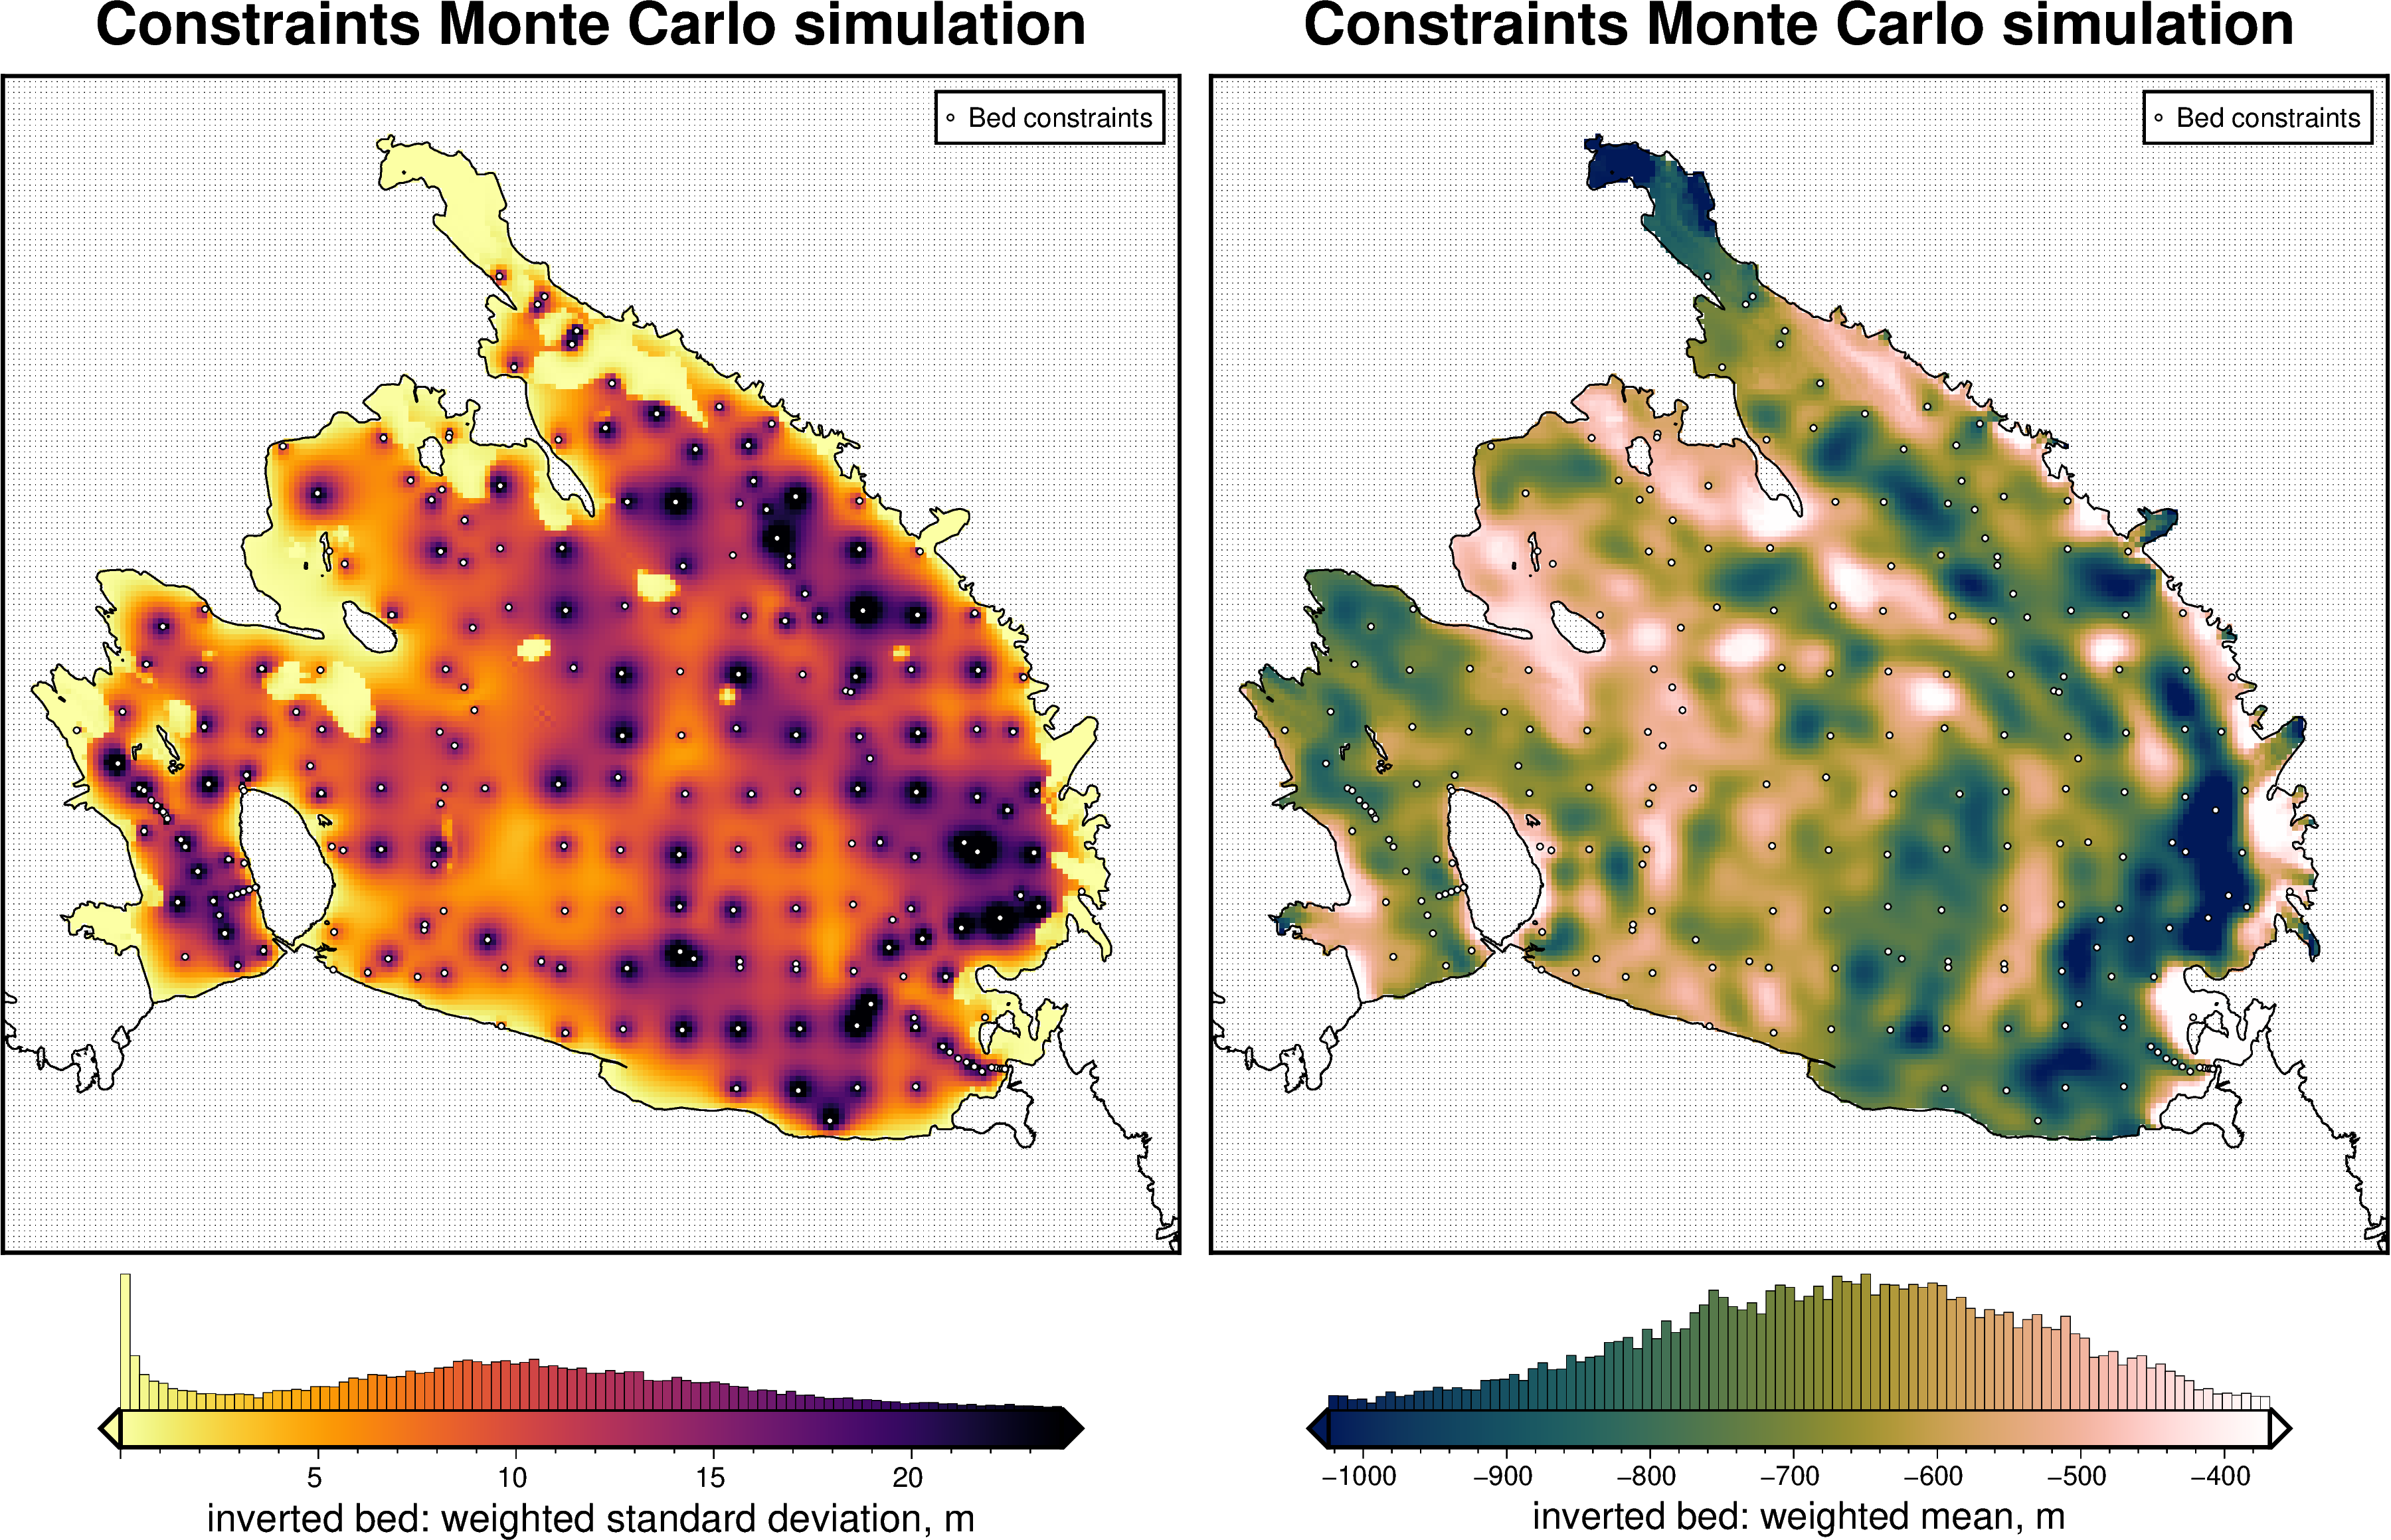

In [223]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_constraints"
# fname = path + prefix

# constraints_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav=True,  # will recalculate regional field
#     sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = constraints_results

# ds = uncert.merged_stats(
#     constraints_results,
#     "topo",
#     "starting_bed",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Constraints Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     constraints_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Constraints Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Densities

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

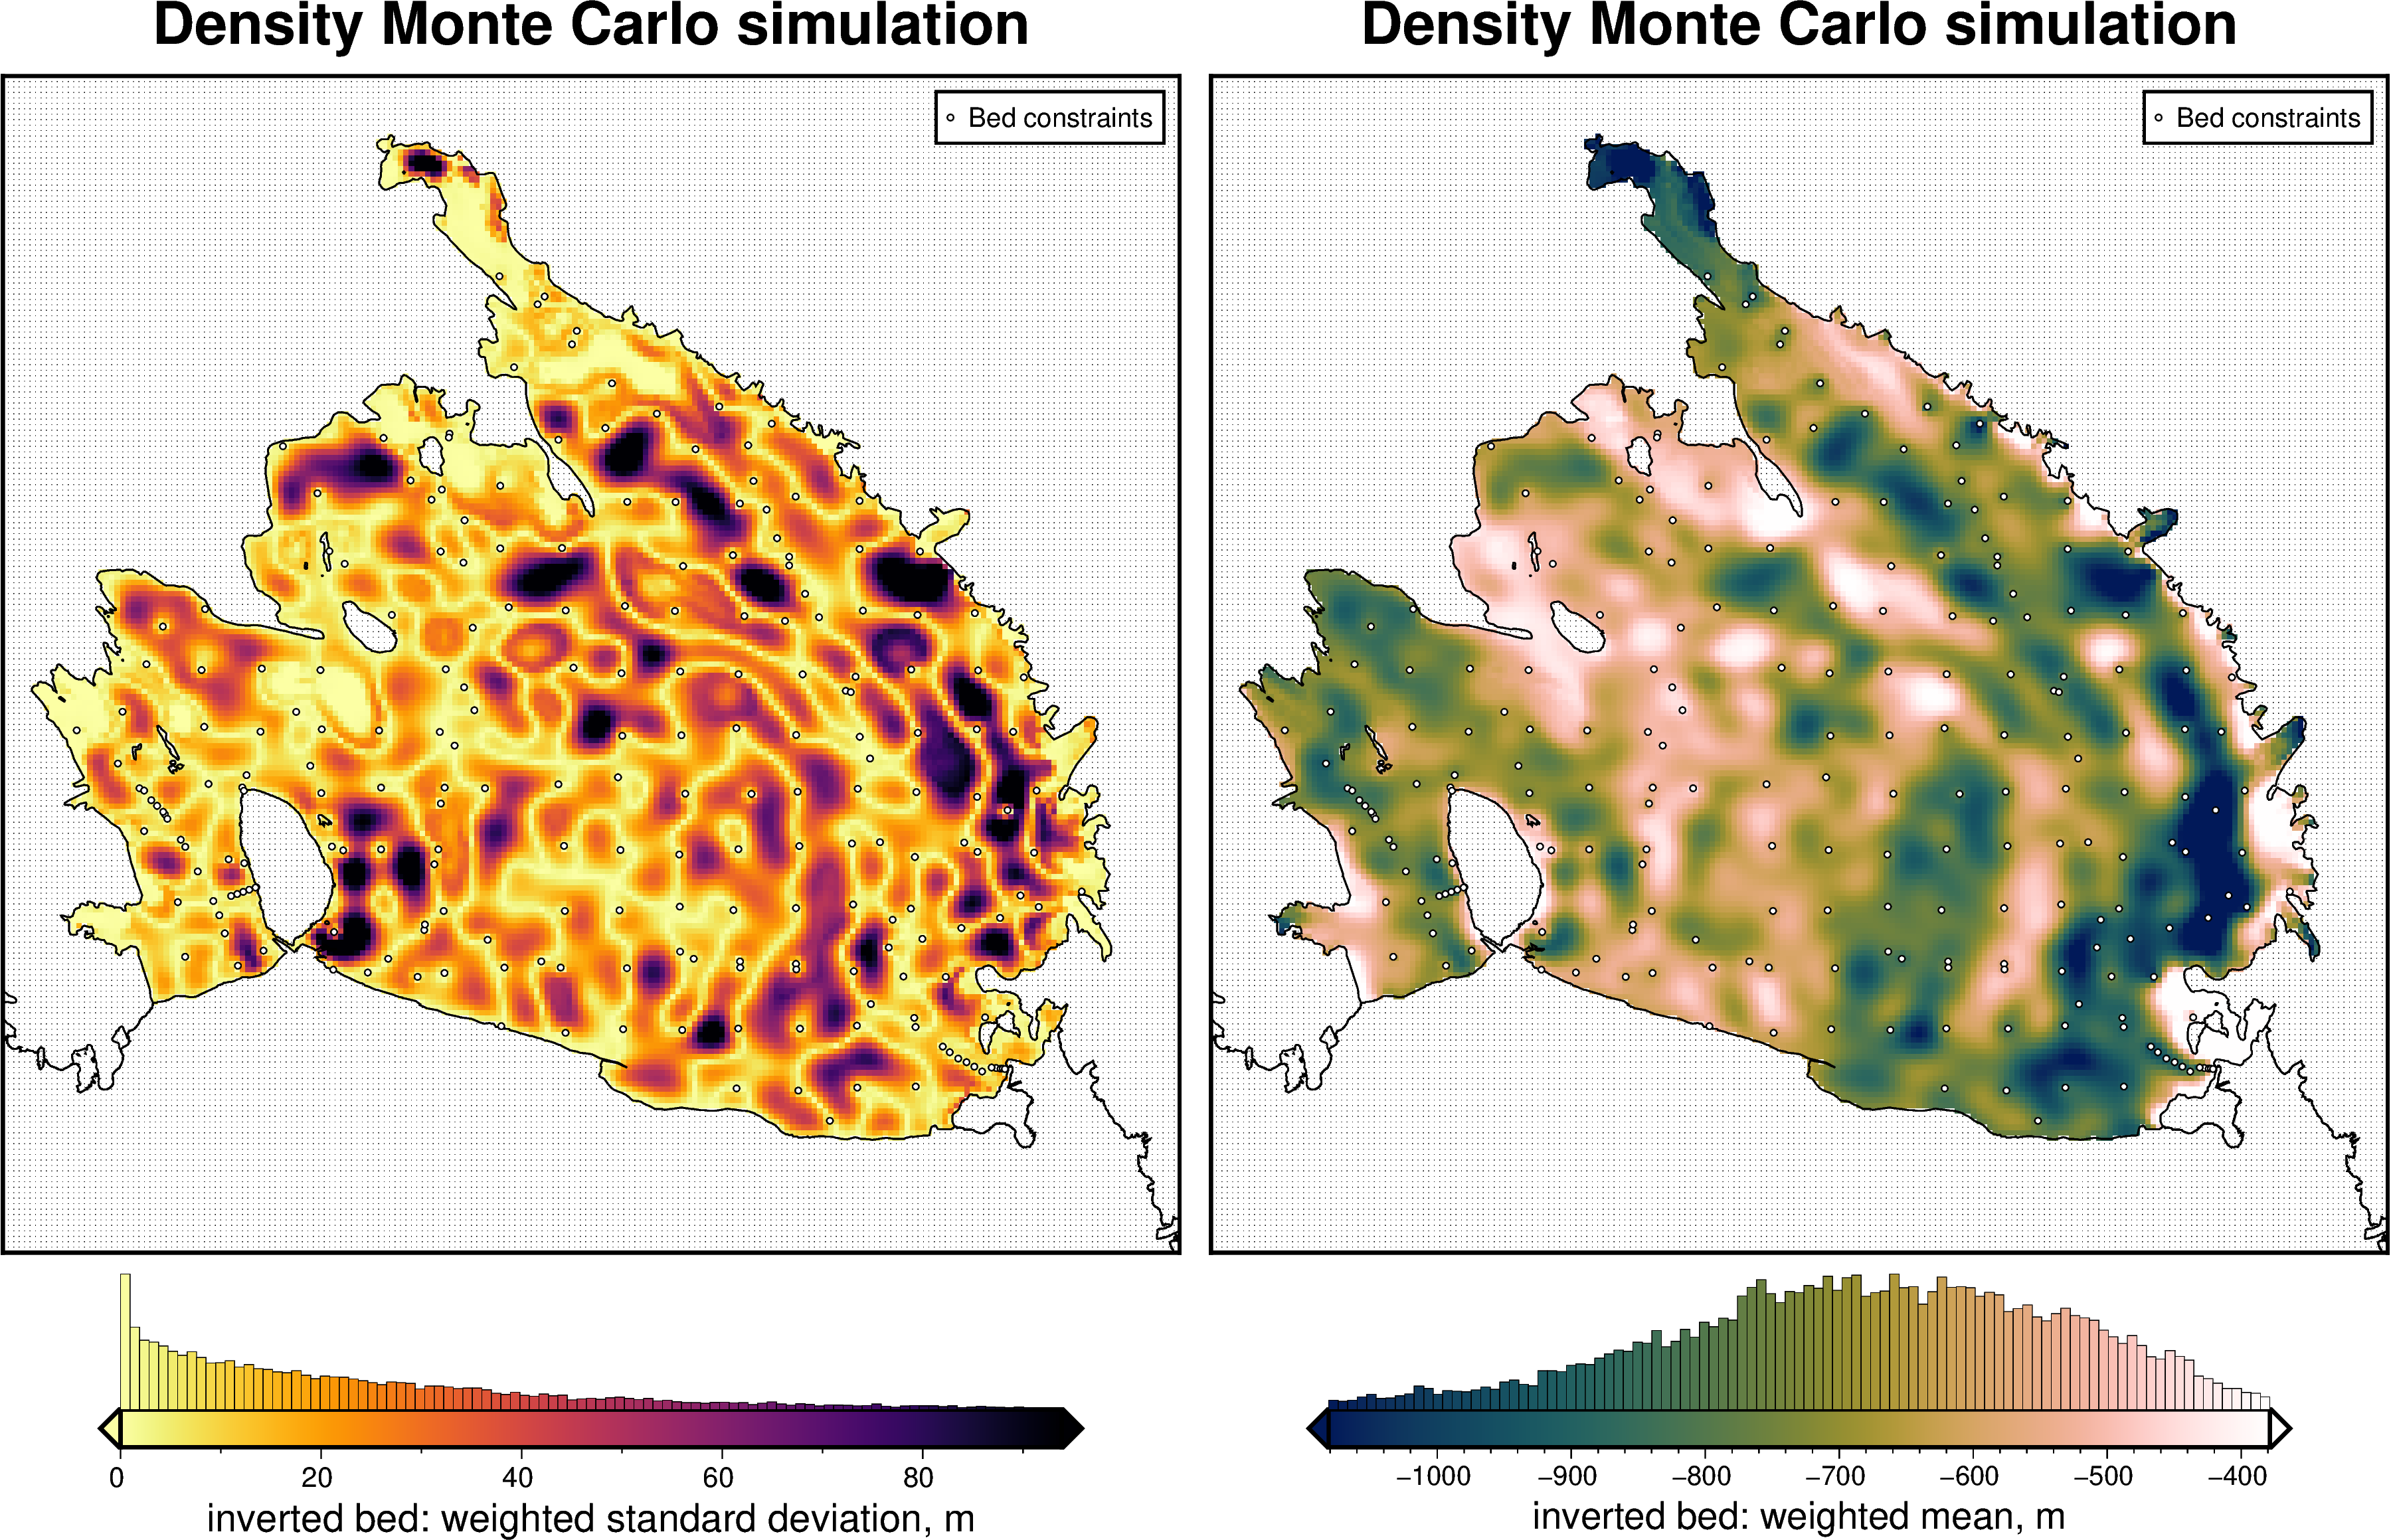

In [224]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_densities"
# fname = path + prefix

# densities_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav=True,  # will recalculate regional field
#     # sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = densities_results

# # ds = uncert.merged_stats(
# #     densities_results,
# #     "grav",
# #     "misfit",
# #     plot=plot,
# #     mask="../plotting/RIS_outline.shp",
# #     title="Density Monte Carlo simulation",
# #     constraints=constraints,
# #     weight_by="constraints",
# # )
# # ds = uncert.merged_stats(
# #     densities_results,
# #     "grav",
# #     "res",
# #     plot=plot,
# #     mask="../plotting/RIS_outline.shp",
# #     title="Density Monte Carlo simulation",
# #     constraints=constraints,
# #     weight_by="constraints",
# # )
# ds = uncert.merged_stats(
#     densities_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

In [41]:
# values_df = pd.DataFrame(values)
# fig, axes = plt.subplots(3, 1)
# sns.histplot(ax=axes[0], data=values_df, x="ice_density", kde=True)
# sns.histplot(ax=axes[1], data=values_df, x="water_density", kde=True)
# sns.histplot(ax=axes[2], data=values_df, x="sediment_density", kde=True)
# fig.show()

In [24]:
# values_df.ice_density.min(), values_df.ice_density.max()

(906.3086680075156, 925.2045956069259)

In [23]:
# values_df.water_density.min(), values_df.water_density.max()

(1008.6083404490098, 1032.882456519085)

In [22]:
# values_df.sediment_density.min(), values_df.sediment_density.max()

(1278.6832646171947, 2965.489596556479)

## Starting bed tension

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

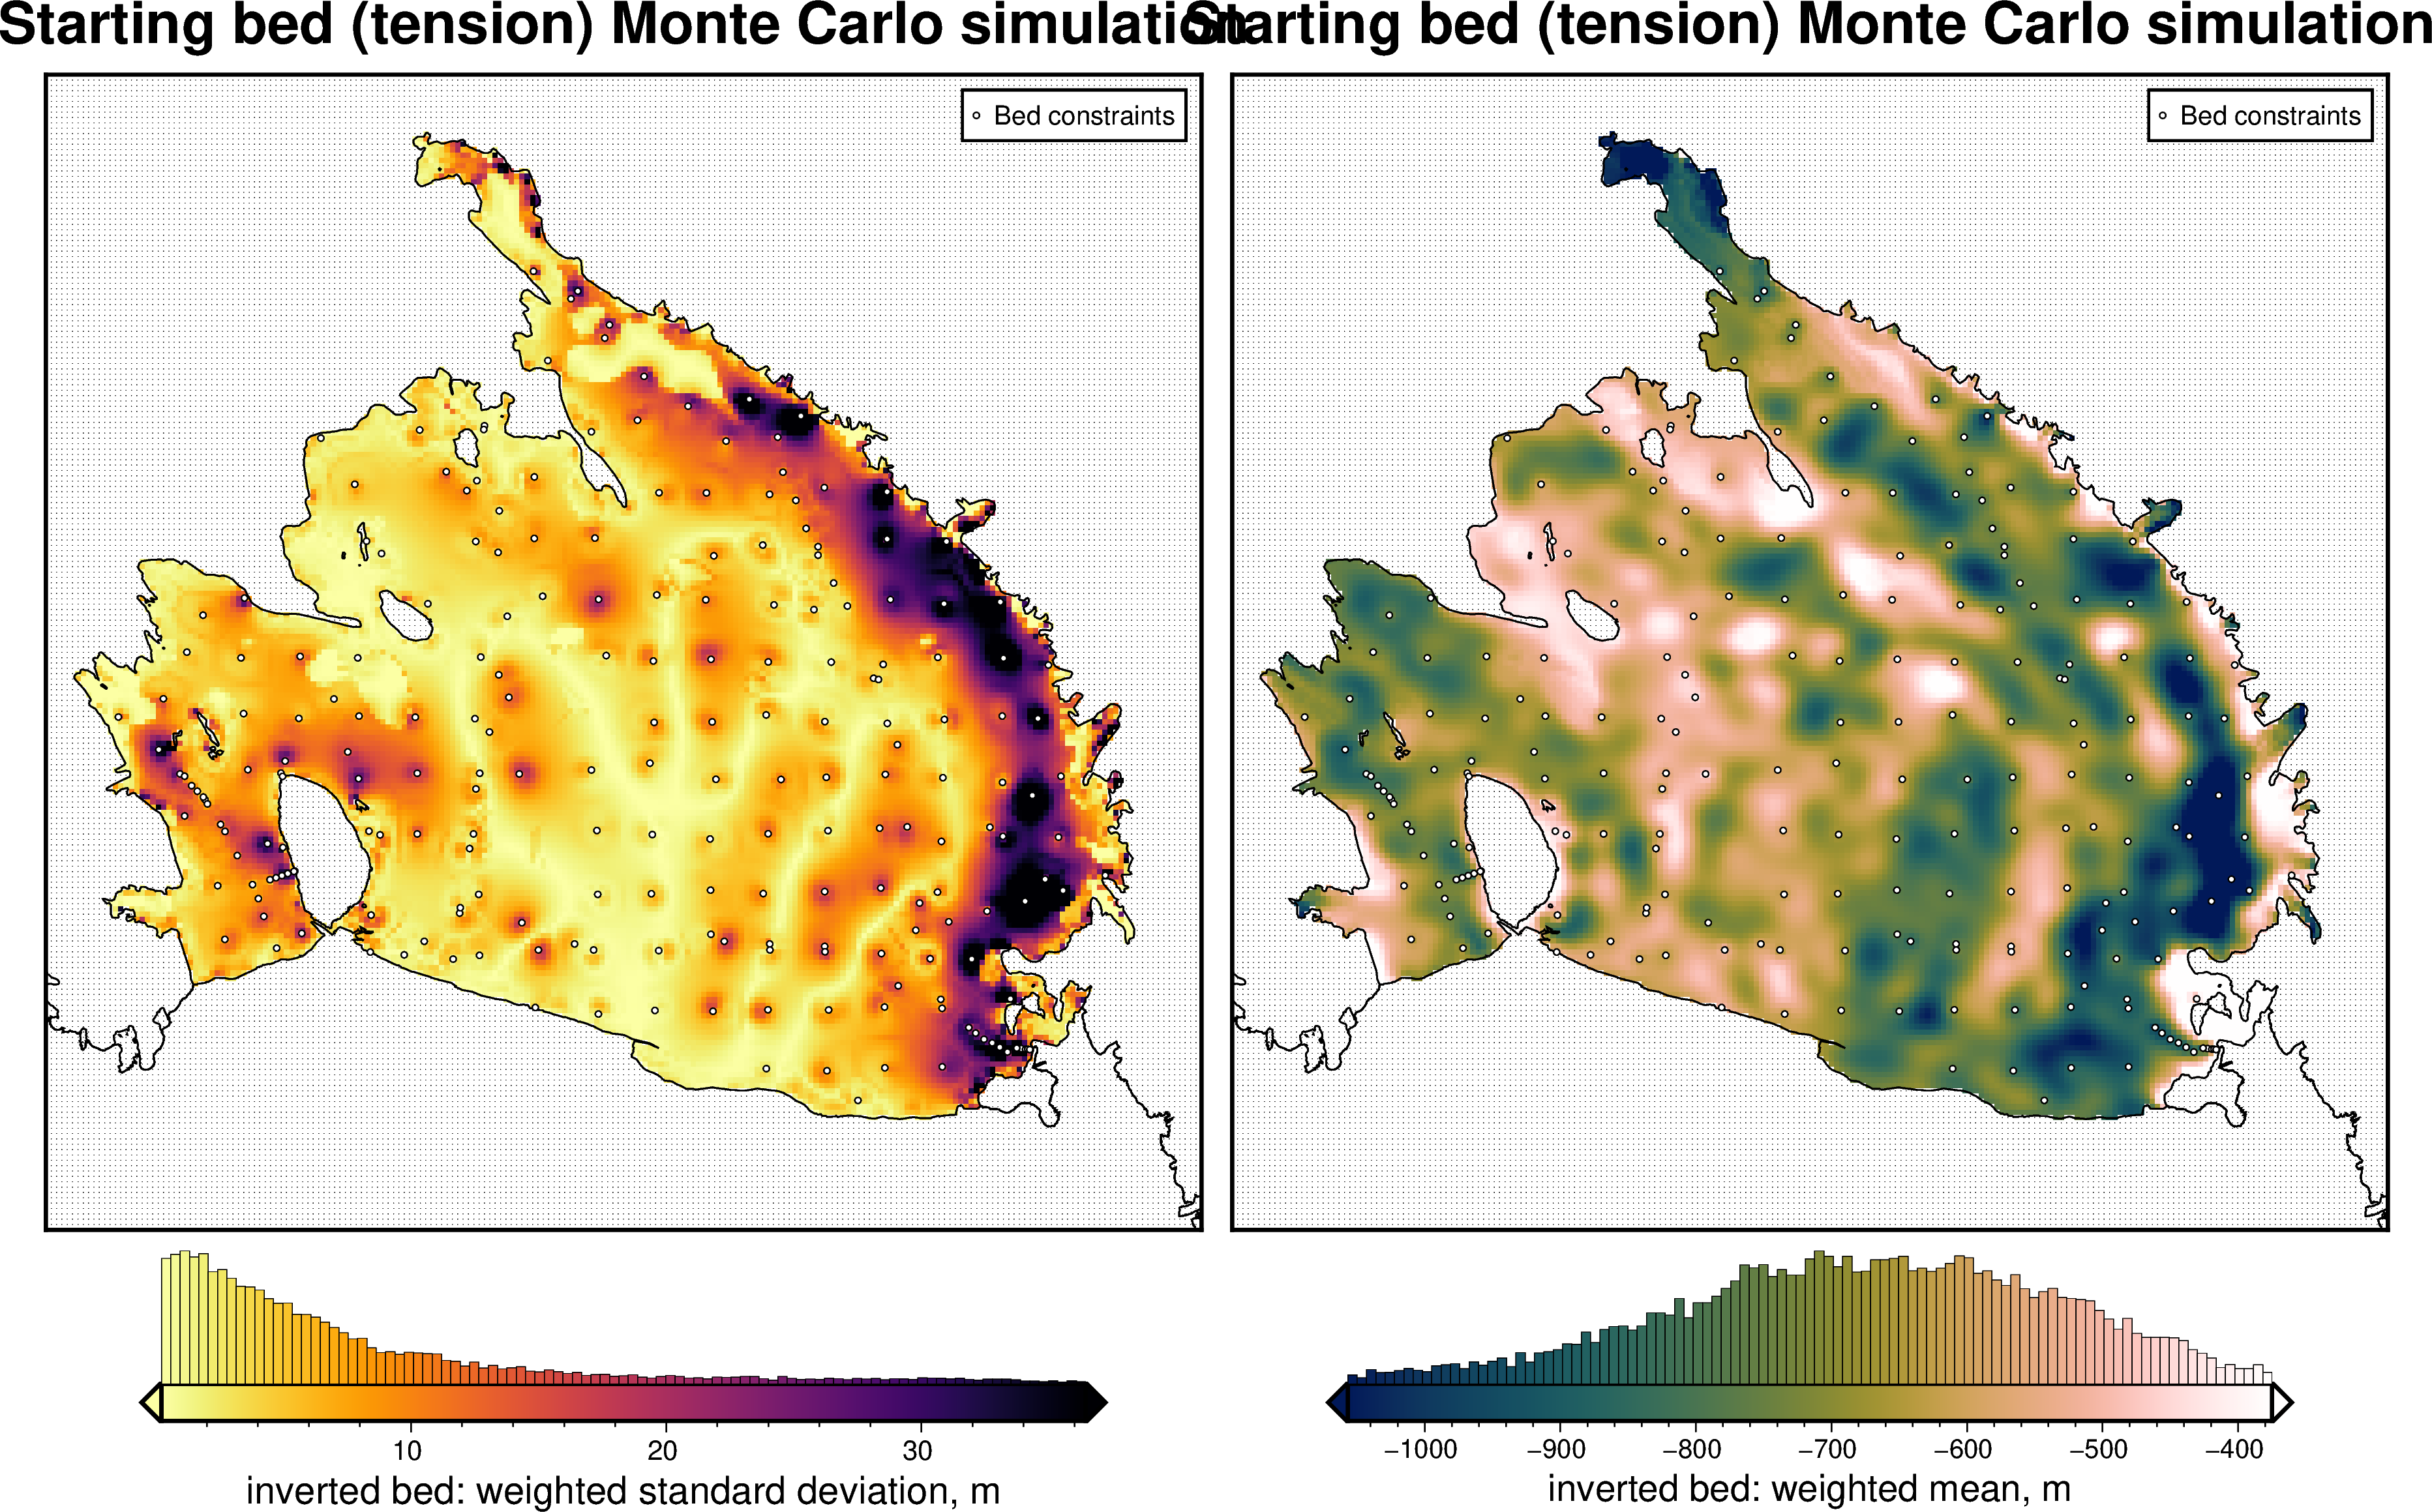

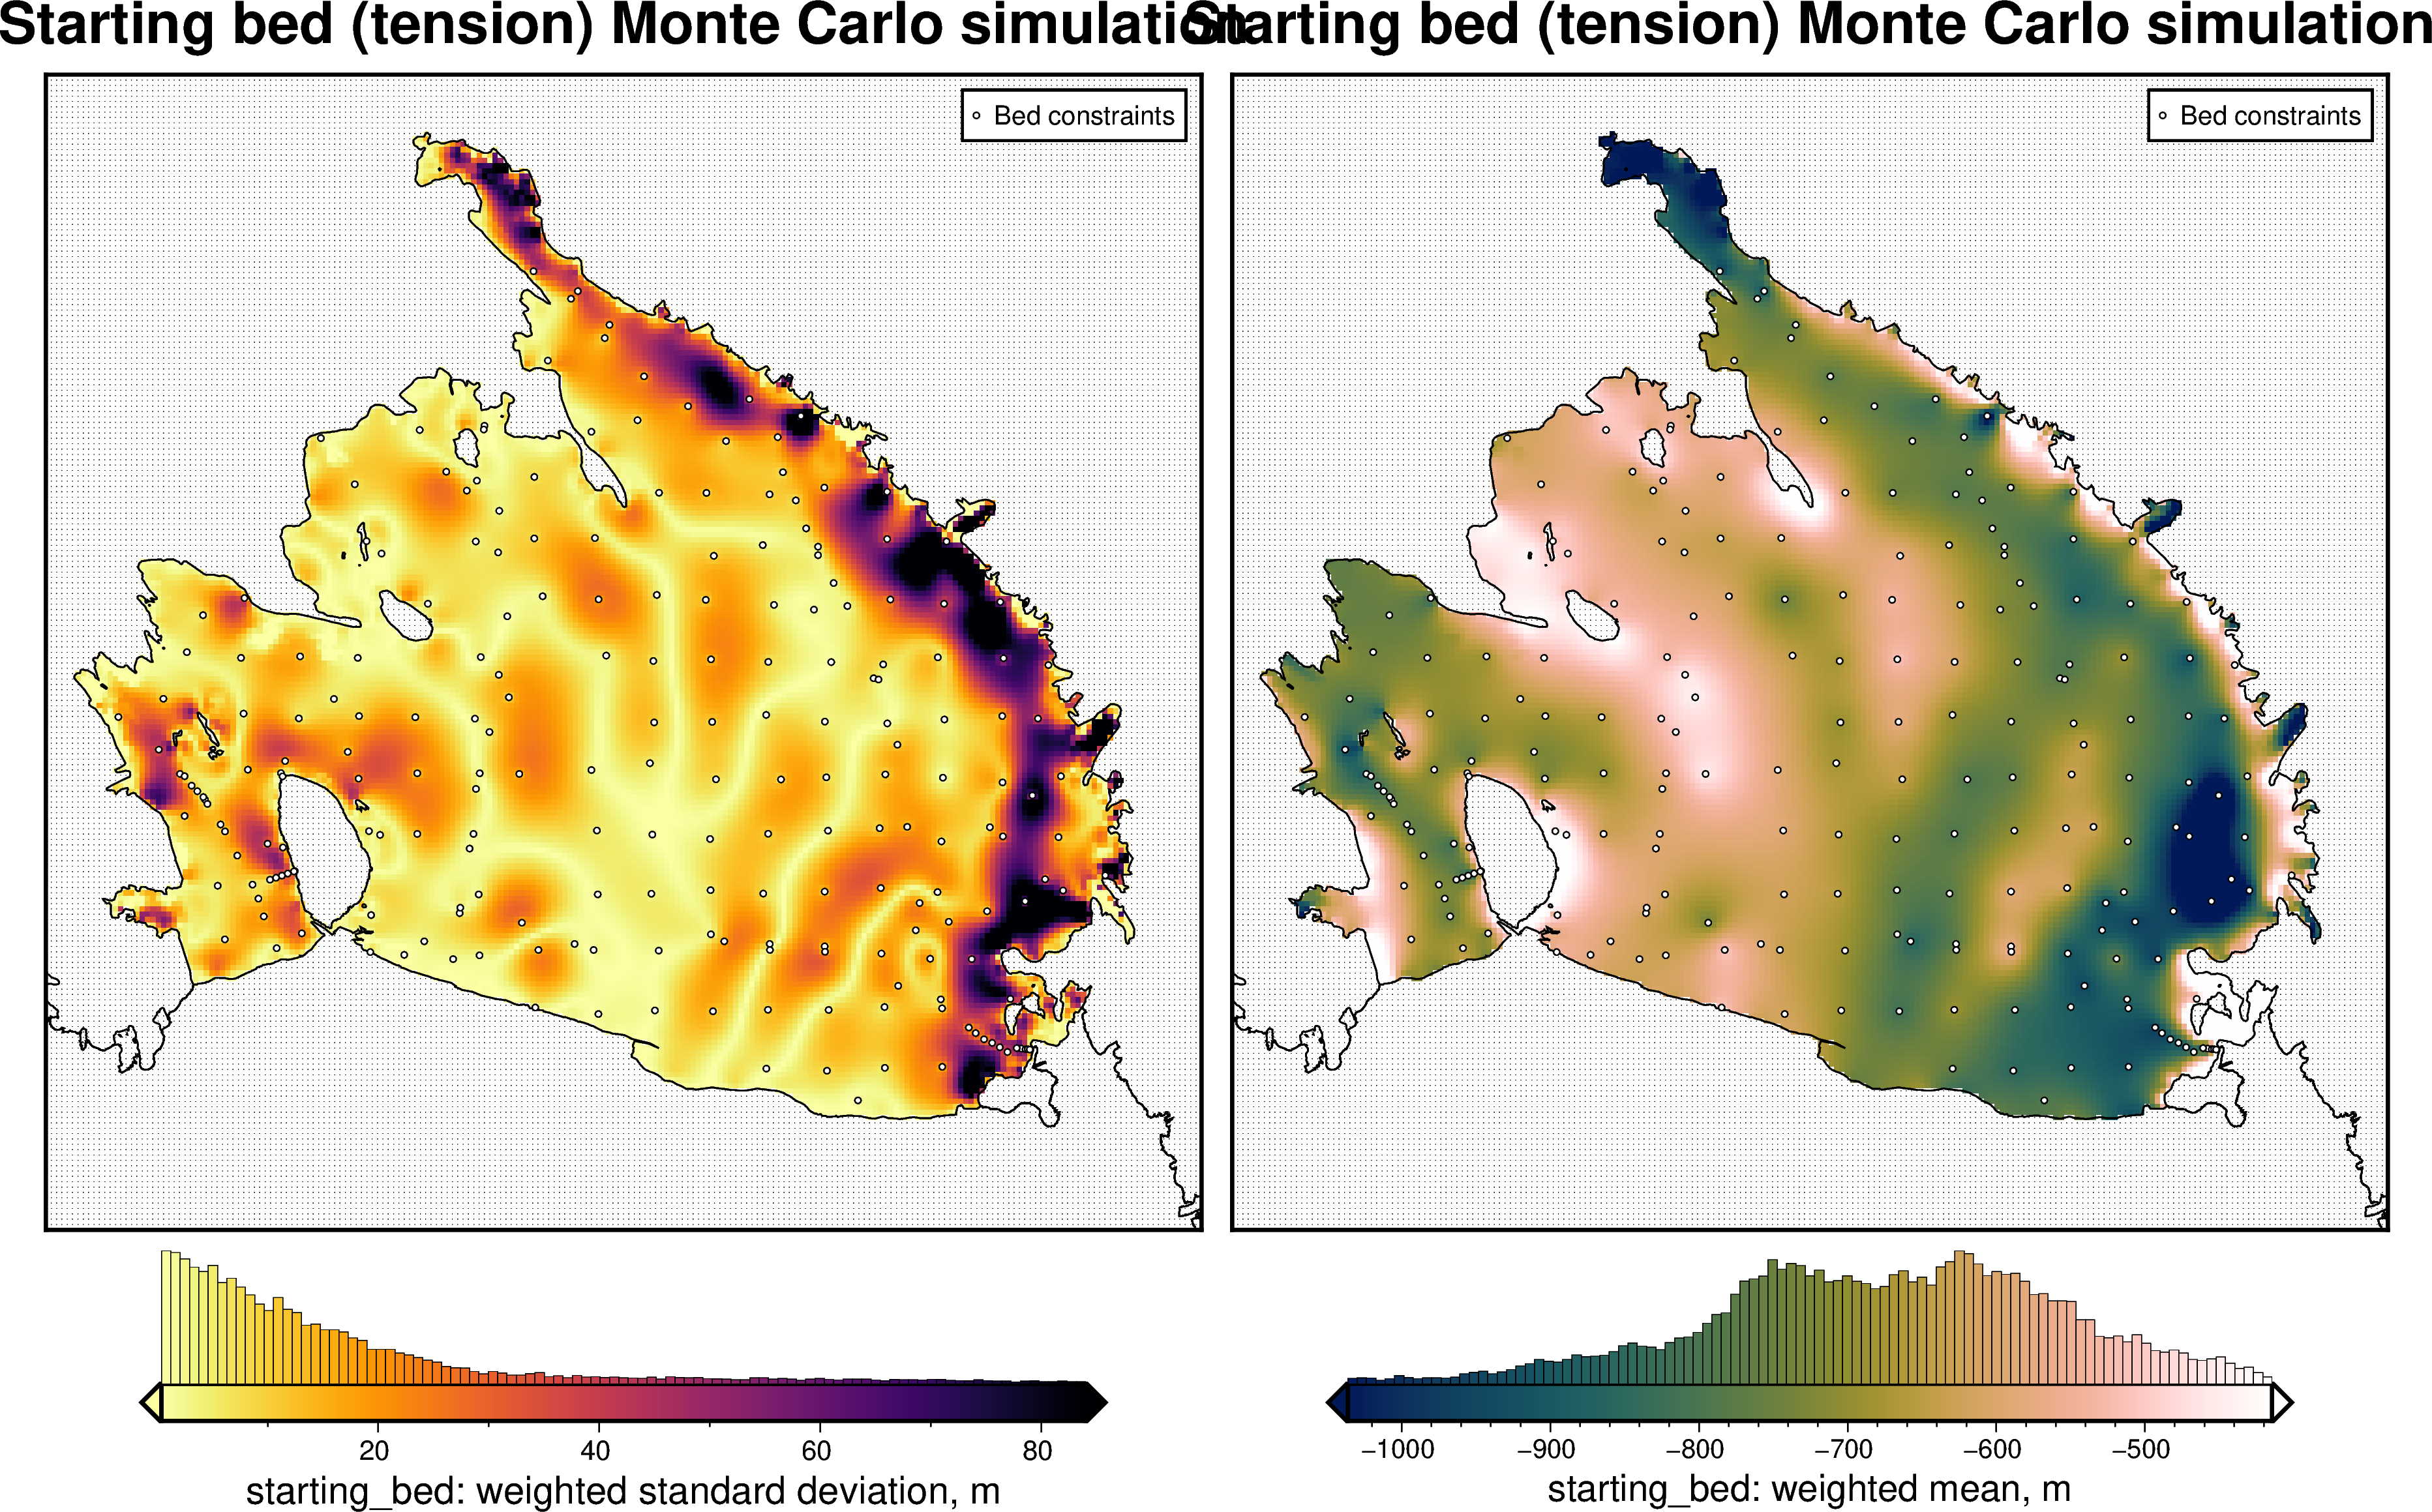

In [19]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_starting_bed_tension"
# fname = path + prefix

# starting_bed_tension_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = starting_bed_tension_results

# ds = uncert.merged_stats(
#     starting_bed_tension_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Starting bed (tension) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     starting_bed_tension_results,
#     "topo",
#     "starting_bed",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Starting bed (tension) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Regional separation tension

all 10 runs already complete, loading results from files.


0it [00:00, ?it/s]

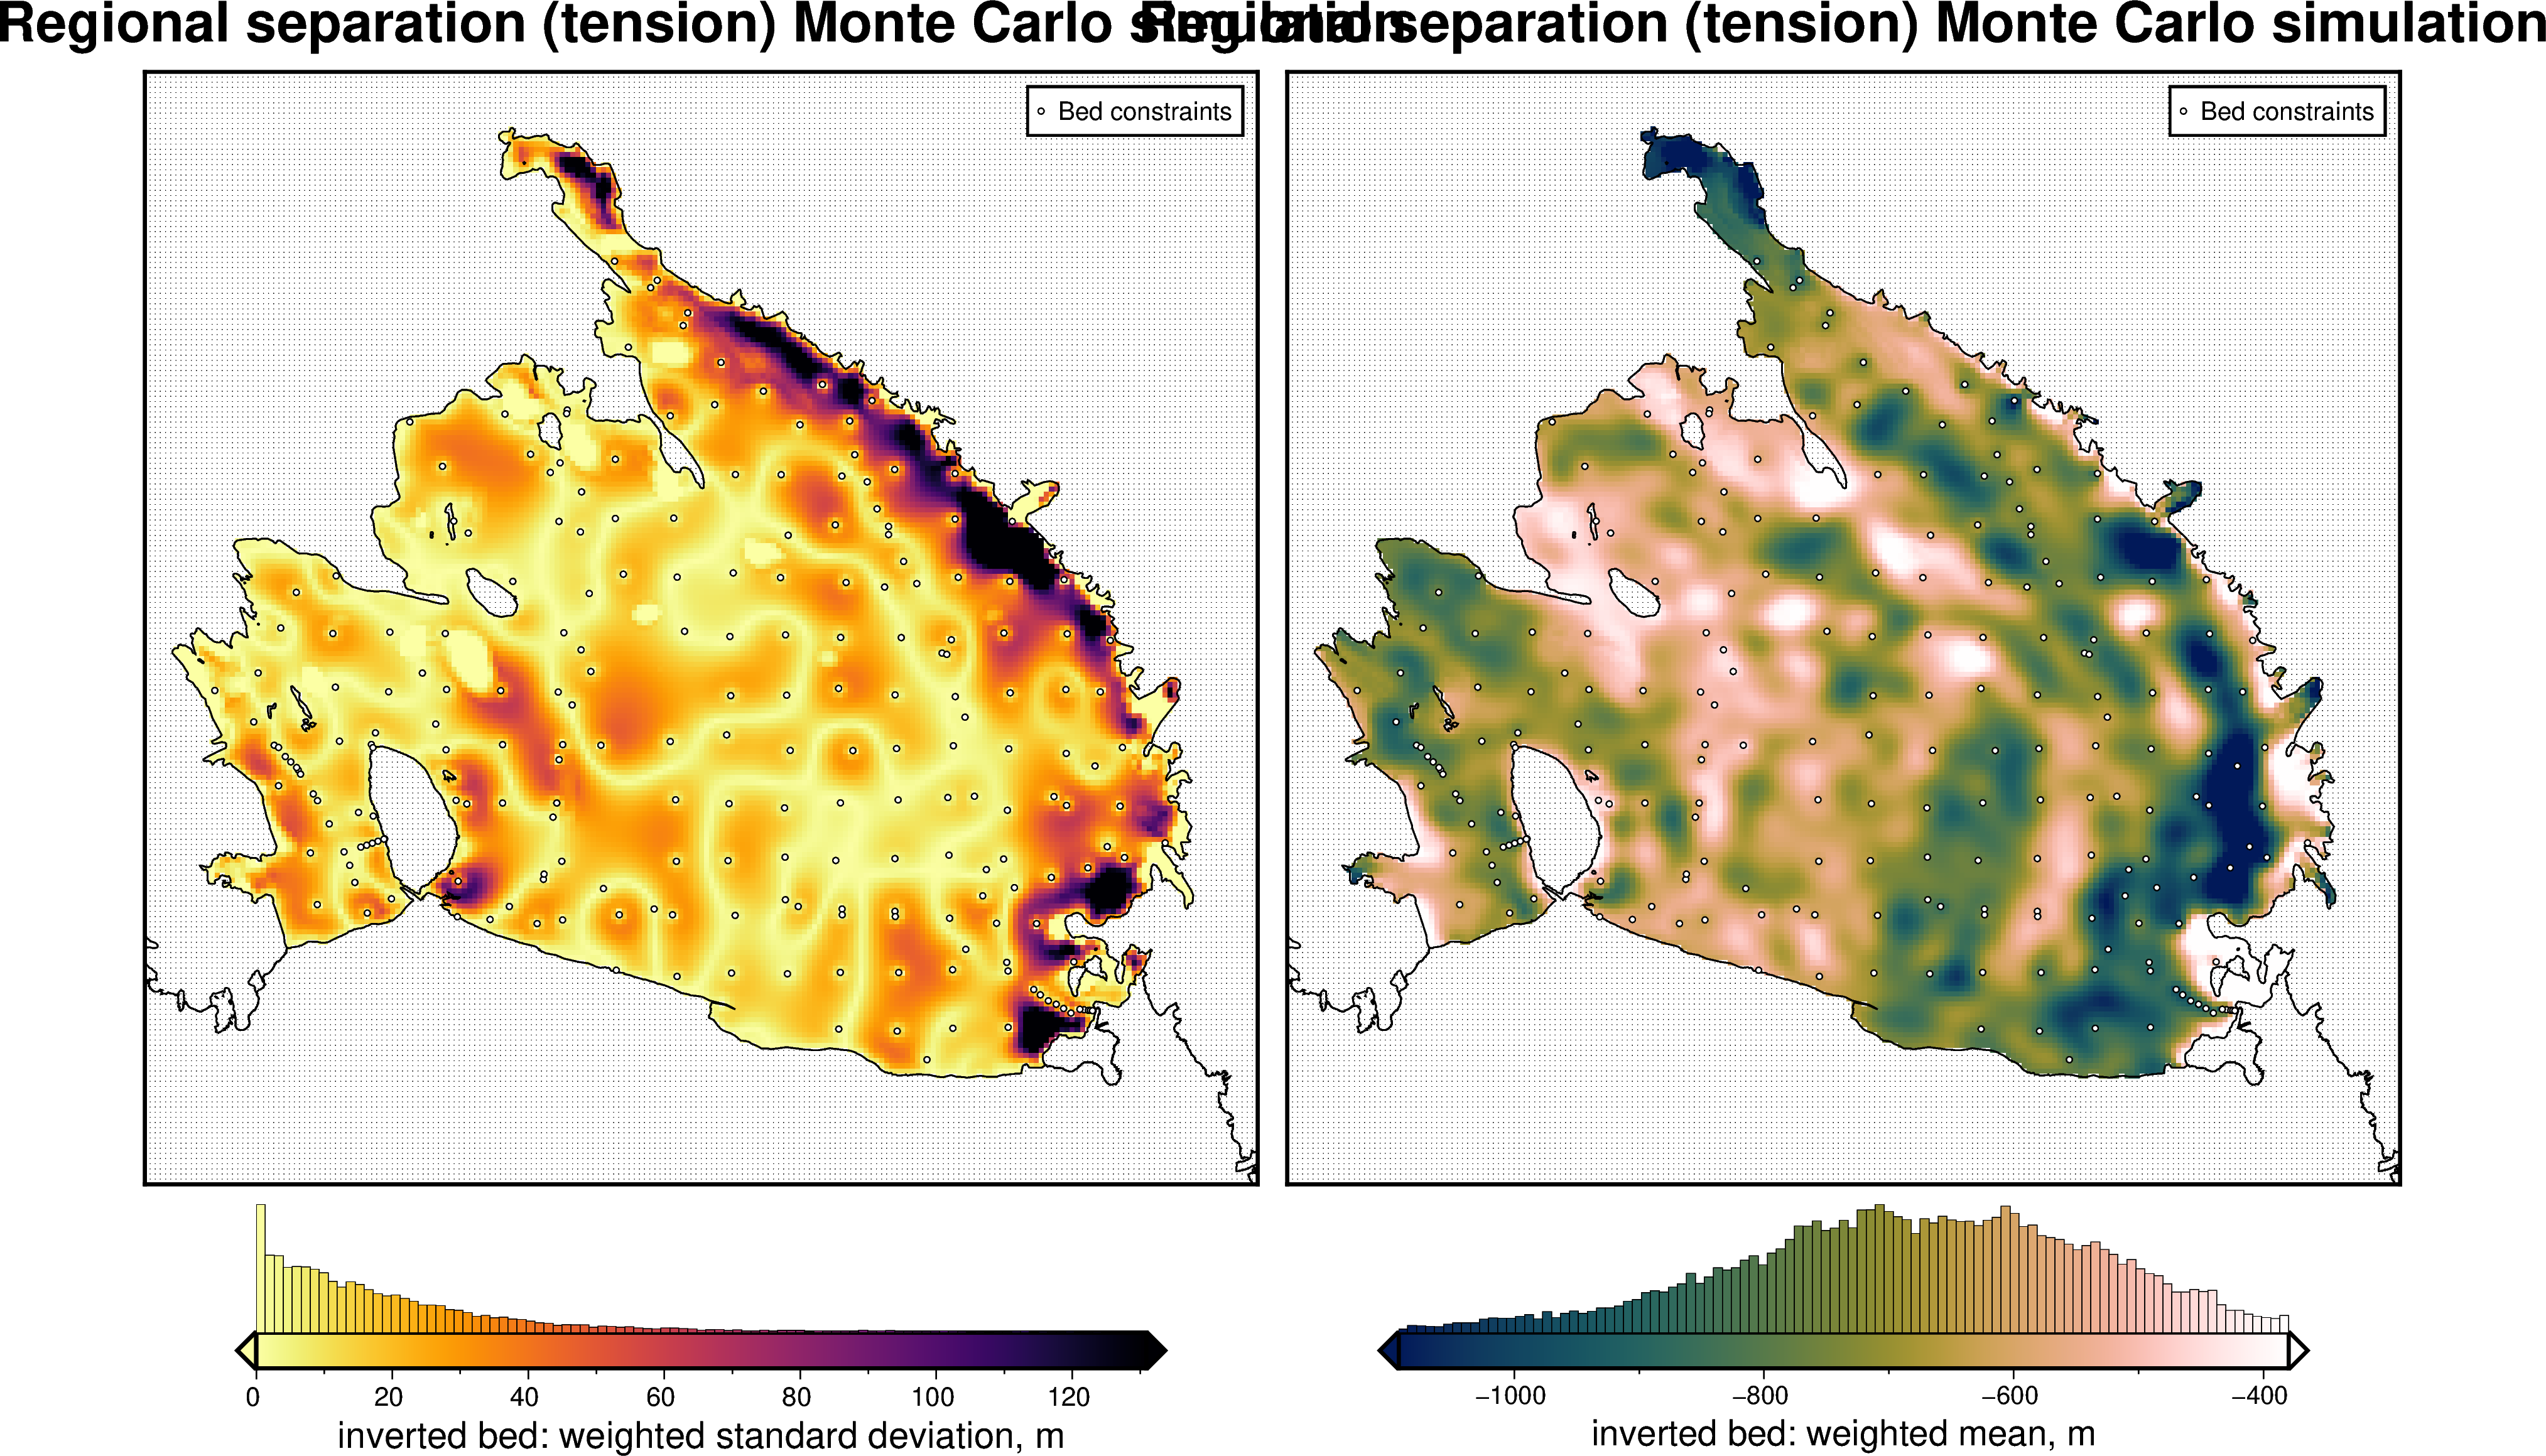

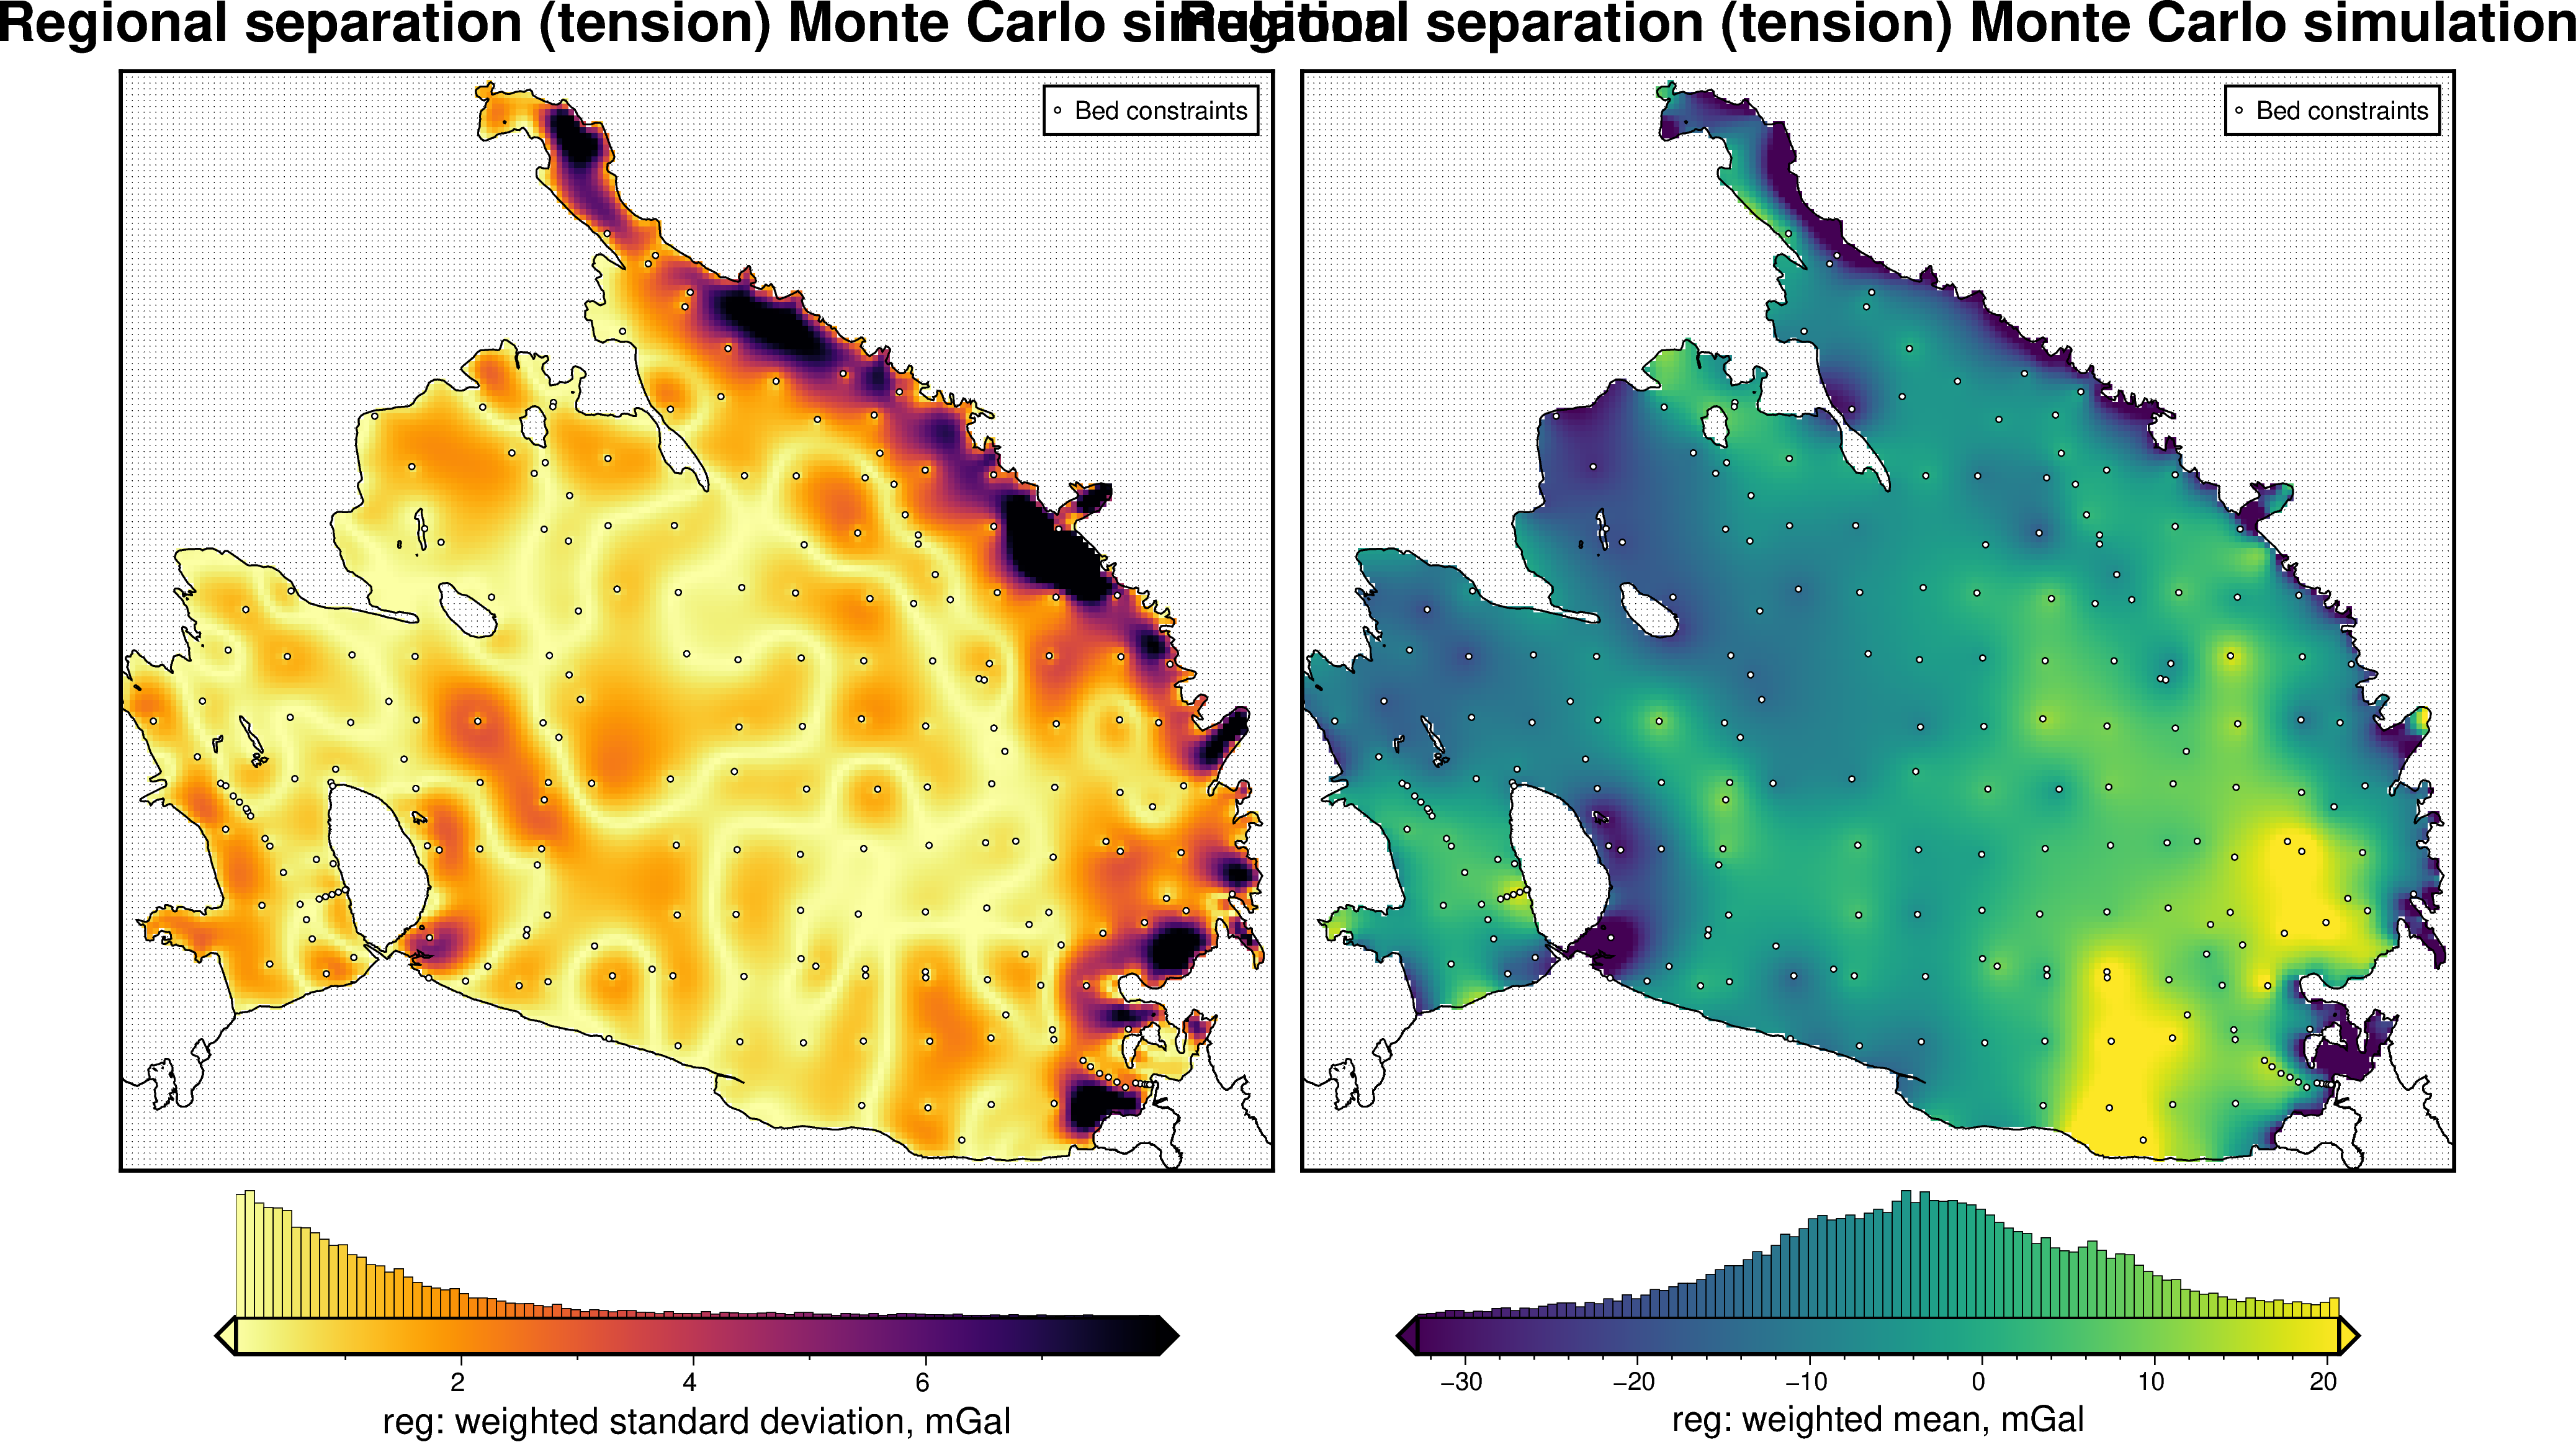

In [20]:
path = "../results/monte_carlo_results/"
prefix = "RIS_monte_carlo_regional_tension"
fname = path + prefix

regional_tension_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
    fname=fname,
    runs=runs,
    grav=df_anomalies,
    constraints=constraints,
    # sample_grav = True,             # will recalculate regional field
    # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field
    # sample_starting_bed_tension=True,
    # sample_starting_bed_damping=True,
    sample_regional_tension_factor=True,
    # sample_regional_damping=True,
    # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
    # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
    # sample_sediment_density=True,  # will recalculate bed gravity and regional field
    run_damping_CV=True,
    damping_CV_fname=path + "damping_CV_results/" + prefix,
    sampling="LHC",
    inversion_args=inversion_args,
    starting_args=starting_args,
    **kwargs,
)

params, values, grav_dfs, prism_dfs = regional_tension_results

ds = uncert.merged_stats(
    regional_tension_results,
    "topo",
    -1,
    plot=plot,
    mask="../plotting/RIS_outline.shp",
    title="Regional separation (tension) Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)
ds = uncert.merged_stats(
    regional_tension_results,
    "grav",
    "reg",
    plot=plot,
    mask="../plotting/RIS_outline.shp",
    title="Regional separation (tension) Monte Carlo simulation",
    constraints=constraints,
    weight_by="constraints",
)

## Data (gravity, constraints)

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_data"
# fname = path + prefix

# data_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     sample_grav = True,             # will recalculate regional field
#     sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = data_results

# ds = uncert.merged_stats(
#     data_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Data (gravity and constraints) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Non-data

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_non_data_tension"
# fname = path + prefix

# non_data_tension_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = non_data_tension_results

# ds = uncert.merged_stats(
#     non_data_tension_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Non-data (tension) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Ice Density

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_ice_density"
# fname = path + prefix

# ice_density_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = ice_density_results

# ds = uncert.merged_stats(
#     ice_density_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Ice density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     ice_density_results,
#     "grav",
#     "ice_surface_grav",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Ice density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Water Density

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_water_density"
# fname = path + prefix

# water_density_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = water_density_results

# ds = uncert.merged_stats(
#     water_density_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Water density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     water_density_results,
#     "grav",
#     "water_surface_grav",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Water density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Sediment Density

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_sediment_density"
# fname = path + prefix

# sediment_density_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = sediment_density_results

# ds = uncert.merged_stats(
#     sediment_density_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Sediment density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     sediment_density_results,
#     "grav",
#     "starting_bed_grav",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Sediment density Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

# Comparing Full, Gravity, Constraints, and Densities

In [ ]:
# results = [
#     full_results,
#     grav_results,
#     constraint_results,
#     densities_results,
# ]

# grids = []
# for i in results:
#     # get final residuals
#     residuals = [utils.RMSE(df[list(df.columns)[-1]]) for df in i[3]]

#     # convert residuals into weights
#     weights = [1 / (x**2) for x in residuals]

#     # calculated stats
#     stats = inv_utils.model_ensemble_stats(i[0], weights=weights)
#     merged, z_mean, z_stdev, results_ds, weighted_stdev, z_min, z_max = stats

#     weighted_stdev = utils.mask_from_shp(
#         shapefile="../data/Ross_Sea_outline.shp",
#         xr_grid=weighted_stdev,
#         masked=True,
#         invert=False,
#     )
#     grids.append(weighted_stdev)

In [ ]:
# import string

# # set color limits
# lims = utils.get_min_max(
#     grids[0],
#     robust=True,
# )

# titles = [
#     "All parameters",
#     "Gravity values",
#     "Constraint depths",
#     "Prism densities",
# ]

# for i, g in enumerate(grids):
#     if i == 0:
#         fig = None
#         origin_shift = "initialize"
#         xshift_amount = None
#         yshift_amount = None
#     # elif i == 2:
#     #     fig = fig
#     #     origin_shift = "both_shift"
#     #     xshift_amount = -1.1
#     #     yshift_amount = -1
#     else:
#         fig = fig
#         origin_shift = "xshift"
#         xshift_amount = 1.1
#         yshift_amount = None

#     fig = maps.plot_grd(
#         g,
#         region=inversion_region,
#         title=titles[i],
#         # title_font = "12p,Helvetica,black",
#         cbar_label="weighted standard deviation (m)",
#         fig_height=10,
#         cmap="inferno",
#         reverse_cpt=True,
#         cpt_lims=lims,
#         points=constraints[constraints.inside].rename(
#             columns={"easting": "x", "northing": "y"}
#         ),
#         points_style="x.2c",
#         points_pen="1.2p",
#         hist=True,
#         hist_bin_num=50,
#         cbar_yoffset=1,
#         fig=fig,
#         origin_shift=origin_shift,
#         xshift_amount=xshift_amount,
#         yshift_amount=yshift_amount,
#     )

#     fig.text(
#         position="TL",
#         justify="BL",
#         text=f"{string.ascii_lowercase[i]})",
#         font="16p,Helvetica-Bold,black",
#         offset="j0c/.4c",
#         no_clip=True,
#     )
#     fig.plot(
#         x=constraints[constraints.inside == False].easting,
#         y=constraints[constraints.inside == False].northing,
#         style="x.05c",
#     )
# fig.show()

## Full (spline)

In [38]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_full_verde_spline"
# fname = path + prefix

# full_spline_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     sample_grav=True,  # will recalculate regional field
#     sample_constraints=True,  # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = full_spline_results

# # ds = uncert.merged_stats(
# #     full_spline_results,
# #     "topo",
# #     "starting_bed",
# #     # plot=False,
# #     mask="../plotting/RIS_outline.shp",
# #     title="Constraints Monte Carlo simulation",
# #     constraints=constraints,
# #     weight_by="constraints",
# # )
# ds = uncert.merged_stats(
#     full_spline_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Full (spline) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Starting bed damping

In [43]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_starting_bed_damping"
# fname = path + prefix

# starting_bed_damping_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     # sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field
#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = starting_bed_damping_results

# ds = uncert.merged_stats(
#     starting_bed_damping_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Starting bed (damping) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     starting_bed_damping_results,
#     "topo",
#     "starting_bed",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Starting bed (damping) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Regional separation damping

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_regional_damping"
# fname = path + prefix

# regional_damping_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     # sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     sample_regional_damping=True,

#     # sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     # sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     # sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = regional_damping_results

# ds = uncert.merged_stats(
#     regional_damping_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Regional separtaion (damping) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )
# ds = uncert.merged_stats(
#     regional_damping_results,
#     "grav",
#     "reg",
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Regional separtaion (damping) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )

## Non data (spline)

In [ ]:
# path = "../results/monte_carlo_results/"
# prefix = "RIS_monte_carlo_non_data_damping"
# fname = path + prefix

# non_data_damping_results = uncert.monte_carlo_full_workflow_uncertainty_loop(
#     fname=fname,
#     runs=runs,
#     grav=df_anomalies,
#     constraints=constraints,

#     # sample_grav = True,             # will recalculate regional field
#     # sample_constraints = True,      # will recalculate starting bed, bed gravity, and regional field

#     # sample_starting_bed_tension=True,
#     sample_starting_bed_damping=True,

#     # sample_regional_tension_factor=True,
#     sample_regional_damping=True,

#     sample_ice_density=True, # will recalculate ice and water gravity, and regional field
#     sample_water_density=True,  # will recalculate water and bed gravity, and regional field
#     sample_sediment_density=True,  # will recalculate bed gravity and regional field

#     run_damping_CV = True,
#     damping_CV_fname = path+"damping_CV_results/"+prefix,

#     sampling="LHC",
#     inversion_args=inversion_args,
#     starting_args=starting_args,
#     **kwargs,
# )

# params, values, grav_dfs, prism_dfs = non_data_damping_results

# ds = uncert.merged_stats(
#     non_data_damping_results,
#     "topo",
#     -1,
#     plot=plot,
#     mask="../plotting/RIS_outline.shp",
#     title="Non-data (damping) Monte Carlo simulation",
#     constraints=constraints,
#     weight_by="constraints",
# )